<a href="https://colab.research.google.com/github/duonghung86/Injury-severity-classification/blob/main/VCA_3_0_binary_models_MLs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.regularizers import l1,l1_l2

2.1.0


# Import dataset

In [2]:
df = pd.read_csv('Prepared Texas 2019.csv')
print(df.shape)
df.head()

(949856, 19)


,Prsn_Injry_Sev,Prsn_Age,Prsn_Gndr,Wthr_Cond,Light_Cond,Surf_Cond,Veh_Body_Styl,Prsn_Rest,Prsn_Drg_Rslt,Harm_Evnt,Rural,Crash_Speed_Limit,Road_Algn,Veh_Mod_Year,Weekend,Crash_season,Part_of_day,Collsn_type,Collsn_name
0,0,26,MALE,CLEAR,DAYLIGHT,DRY,"PASSENGER CAR, 2-DOOR",SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,0,-1,"STRAIGHT, LEVEL",33,1,3,3,SAME DIRECTION,ONE STRAIGHT-ONE LEFT TURN
1,0,52,MALE,CLEAR,DAYLIGHT,DRY,"PASSENGER CAR, 2-DOOR",SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,0,-1,"STRAIGHT, LEVEL",19,1,3,3,SAME DIRECTION,ONE STRAIGHT-ONE LEFT TURN
2,0,27,FEMALE,CLEAR,DAYLIGHT,DRY,PICKUP,SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,1,-1,"CURVE, LEVEL",16,1,3,4,SAME DIRECTION,BOTH LEFT TURN
3,0,44,MALE,CLEAR,DAYLIGHT,DRY,PICKUP,SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,1,-1,"CURVE, LEVEL",4,1,3,4,SAME DIRECTION,BOTH LEFT TURN
4,0,50,FEMALE,CLEAR,DAYLIGHT,DRY,SPORT UTILITY VEHICLE,SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,0,-1,"STRAIGHT, LEVEL",16,1,3,4,ANGLE,BOTH GOING STRAIGHT


In [3]:
#create a back up
backup_df = df.copy()

In [4]:
# Let's just use 20% of the total dataset
df, _ = train_test_split(df, test_size=0.7,stratify = df['Prsn_Injry_Sev'])
df.shape

(189971, 19)

In [5]:
y=df['Prsn_Injry_Sev']
y.value_counts()

0    158512
1     20482
2      9048
3      1590
4       339
Name: Prsn_Injry_Sev, dtype: int64

In [6]:
X = df.drop(columns=['Prsn_Injry_Sev'])
X.shape

(189971, 18)

In [7]:
emb_vars, ind_vars, num_vars = [], [], []
for var in X.columns:
    if X[var].dtypes == 'O':
        if len(X[var].unique())>5:
            emb_vars.append(var)
        else:
            ind_vars.append(var)
    else:
        num_vars.append(var)
print('Numerical variables are ',num_vars)
print('Categorical variables that have at most 5 categories are ',ind_vars)
print('Categorical variables that have more than 5 categories are ',emb_vars)

Numerical variables are  ['Prsn_Age', 'Rural', 'Crash_Speed_Limit', 'Veh_Mod_Year', 'Weekend', 'Crash_season', 'Part_of_day']
Categorical variables that have at most 5 categories are  ['Prsn_Gndr', 'Prsn_Drg_Rslt', 'Collsn_type']
Categorical variables that have more than 5 categories are  ['Wthr_Cond', 'Light_Cond', 'Surf_Cond', 'Veh_Body_Styl', 'Prsn_Rest', 'Harm_Evnt', 'Road_Algn', 'Collsn_name']


In [8]:
from tensorflow import feature_column

In [9]:
feature_columns = []
# numeric cols
for header in num_vars:
    feature_columns.append(feature_column.numeric_column(header,
                                                         ))

In [10]:
# bucketized cols
#age = feature_column.numeric_column('Prsn_Age')
#age_buckets = feature_column.bucketized_column(age, boundaries=[16, 22, 35, 55, 65])
#feature_columns.append(age_buckets)

In [11]:
# indicator_columns
for col_name in ind_vars:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(
        col_name, X[col_name].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)

In [12]:
# embedding columns
for col_name in emb_vars:
    emb_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, X[col_name].unique())
    col_embedding = feature_column.embedding_column(emb_column, dimension=5)
    feature_columns.append(col_embedding)

In [13]:
feature_columns[0::4]

[NumericColumn(key='Prsn_Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Weekend', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Prsn_Drg_Rslt', vocabulary_list=('Not Applicable', 'Unknown', 'Positive', 'Negative'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Surf_Cond', vocabulary_list=('DRY', 'WET', 'UNKNOWN', 'STANDING WATER', 'SAND, MUD, DIRT', 'OTHER (EXPLAIN IN NARRATIVE)', 'SNOW', 'ICE', 'SLUSH'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=5, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x2af8903bd358>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True),
 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Road_Algn', vocabulary_list=('STR

In [14]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
X = feature_layer(dict(X)).numpy()
X.shape

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


(189971, 59)

In [15]:
X[:5,:5]

array([[-0.2914035 ,  0.28503555,  0.4108008 , -0.03203921,  0.2852243 ],
       [ 0.13625224,  0.18643603, -0.1712459 ,  0.6571874 , -0.05009079],
       [-0.03337865, -0.10446271,  0.4425432 , -0.5894858 , -0.51245296],
       [-0.29694048, -0.749523  , -0.3399897 ,  0.20951106,  0.26488814],
       [-0.2914035 ,  0.28503555,  0.4108008 , -0.03203921,  0.2852243 ]],
      dtype=float32)

# Split the dataset

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y, random_state=48)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,stratify=y_train, random_state=48)

#X_train=np.array(X_train)
#X_test=np.array(X_test)
#X_val=np.array(X_val)

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

Training features shape: (121580, 59)
Validation features shape: (30396, 59)
Test features shape: (37995, 59)


In [18]:
# standardization
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# PCA

In [20]:
from sklearn.decomposition import PCA

## Function to compute performance


In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import auc

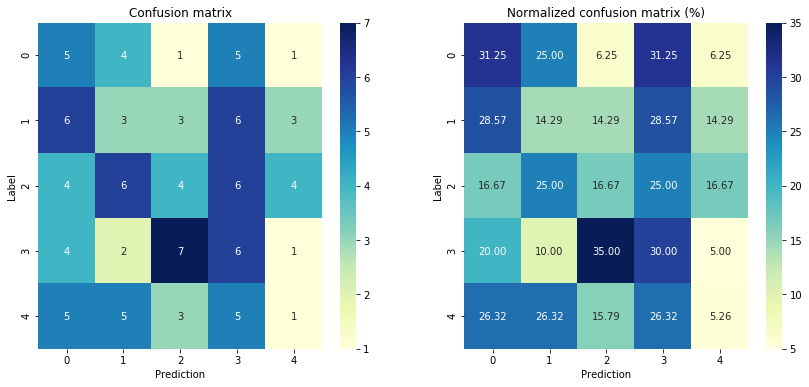

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm
0,0.3125,0.142857,0.166667,0.3,0.052632,0.19,0.163679,0.17684


In [23]:
def get_accs(label,prediction, show=True):
    cm = confusion_matrix(label,prediction)
    length = cm.shape[0]
    num_cases = len(label)
    # global accuracy
    glb_acc = np.trace(cm)/len(label)
    ind_accs = cm/np.sum(cm,axis=1)[:, np.newaxis]
    accs = [ind_accs[i,i] for i in range(length)]
    index = ['Class {}'.format(i) for i in range(length)]
    #Global accuracy
    accs.append(glb_acc)
    index.append('Overall Accuracy')
    # G-mean
    accs.append(geometric_mean_score(label, prediction,correction=0.001))
    index.append('G-mean')
    # Average perf
    accs.append((glb_acc+accs[-1])/2)
    index.append('Avg_Pfm')
    if show:
        plt.figure(figsize=(14, 6))
        plt.subplot(1,2,1)
        sns.heatmap(cm, xticklabels=np.arange(length), yticklabels=np.arange(length), 
                    annot=True, fmt='g',cmap="YlGnBu")
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.title('Confusion matrix')
        plt.subplot(1,2,2)
        sns.heatmap(ind_accs*100, xticklabels=np.arange(length), yticklabels=np.arange(length), 
                    annot=True, fmt='.2f',cmap="YlGnBu")
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.title('Normalized confusion matrix (%)')
        plt.show()
    out = np.array(accs).reshape(1,len(accs))
    return pd.DataFrame(out,columns = index)
get_accs(np.random.randint(5, size=100),np.random.randint(5, size=100))

# Traditional ML

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

LR


/home/tduong21/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


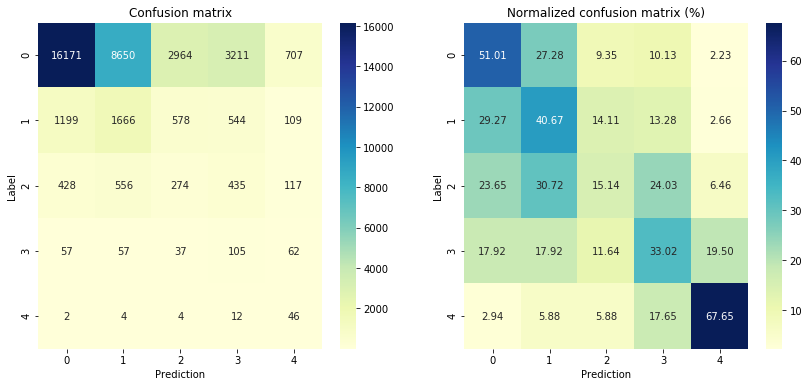

DT


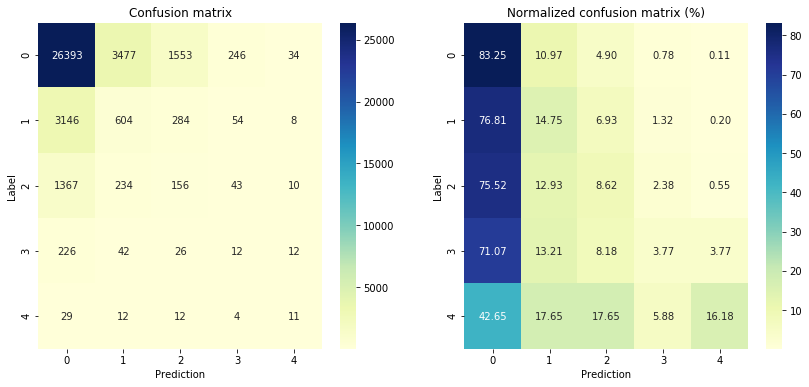

RF


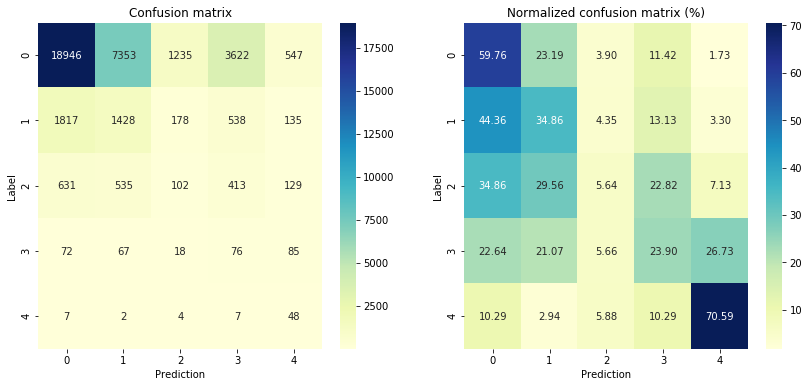

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
LR,0.510078,0.406738,0.151381,0.330189,0.676471,0.480642,0.370857,0.425750,5.689
DT,0.832508,0.147461,0.086188,0.037736,0.161765,0.715252,0.145221,0.430237,1.494
RF,0.597609,0.348633,0.056354,0.238994,0.705882,0.542177,0.287982,0.415079,4.035


In [25]:
cls_wgt='balanced'
LR = LogisticRegression(solver = 'lbfgs',class_weight=cls_wgt)
DT = DecisionTreeClassifier(class_weight=cls_wgt)
RF = RandomForestClassifier(max_depth=4,class_weight=cls_wgt)
GNB = GaussianNB()
#CNB = ComplementNB()
SGD = SGDClassifier(loss="hinge", penalty="l2", max_iter=5,class_weight=cls_wgt)

clfs = [LR,DT,RF]
clf_names = ['LR','DT','RF']
rsts = pd.DataFrame()
for model, name in zip(clfs,clf_names):
    start = time.time()
    print(name)
    model.fit(X_train, y_train.values)
    # use the model to make predictions with the test data
    y_pred = model.predict(X_test)
    end= time.time()
    # get the evaluation metrics
    result = get_accs(y_test.values,y_pred,True)
    result['Training Time'] = np.round(end-start,3)
    result.index = [name]
    rsts = rsts.append(result)
rsts

In [1]:
# Constant for MLP
EPOCH = 50
BATCH_SIZE = 2048

## Model 0 with weight

In [26]:
# Add weights
weights = len(y) / (5 * np.bincount(y))
cls_wgt = dict(zip(np.arange(5),weights))
cls_wgt

{0: 0.23969289391339457,
 1: 1.8550043941021384,
 2: 4.199182139699381,
 3: 23.89572327044025,
 4: 112.07728613569321}

In [27]:
#function to display the evolution of training process:
def show_evolution(monitor):
  hist = pd.DataFrame(monitor.history)
  names = hist.columns
  fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(6,2),dpi=150)
  hist[['loss','val_loss']].plot(ax=axes[0])
  hist[['accuracy','val_accuracy']].plot(ax=axes[1])
  plt.show()

In [28]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

Train on 121580 samples, validate on 30396 samples
Epoch 1/10
121580/121580 [==============================] - 6s 49us/sample - loss: 1.1158 - accuracy: 0.8116 - val_loss: 1.0704 - val_accuracy: 0.8344
Epoch 2/10
121580/121580 [==============================] - 6s 46us/sample - loss: 1.0717 - accuracy: 0.8344 - val_loss: 1.0704 - val_accuracy: 0.8344
Epoch 3/10
121580/121580 [==============================] - 6s 46us/sample - loss: 1.0707 - accuracy: 0.8344 - val_loss: 1.0704 - val_accuracy: 0.8344
Epoch 4/10
121580/121580 [==============================] - 6s 47us/sample - loss: 1.0705 - accuracy: 0.8344 - val_loss: 1.0704 - val_accuracy: 0.8344
Epoch 5/10
121580/121580 [==============================] - 6s 46us/sample - loss: 1.0704 - accuracy: 0.8344 - val_loss: 1.0704 - val_accuracy: 0.8344
Epoch 6/10
121580/121580 [==============================] - 6s 46us/sample - loss: 1.0704 - accuracy: 0.8344 - val_loss: 1.0704 - val_accuracy: 0.8344
Epoch 7/10
121580/121580 [=================

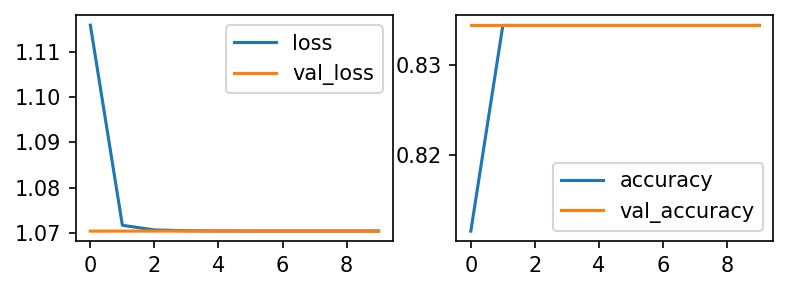

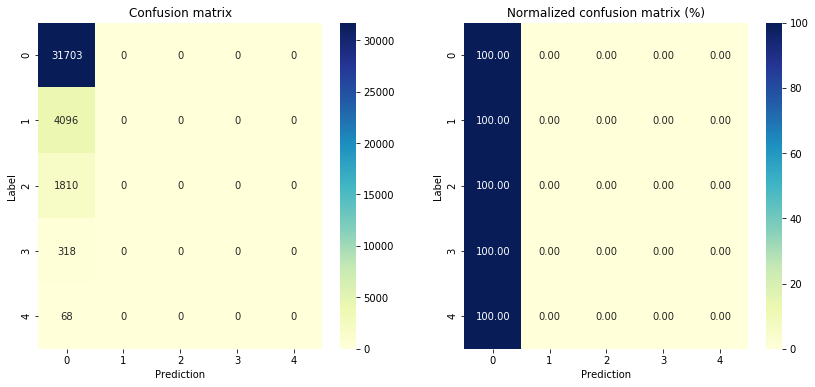

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
MLP with weights,1.0,0.0,0.0,0.0,0.0,0.834399,0.003981,0.41919,56.375


In [29]:
model = tf.keras.Sequential([
  layers.Dense(10, activation='relu',input_dim=X_train.shape[1]),

    #  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(5,activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
start =time.time()
Monitor_MLP = model.fit(X_train, y_train.values, callbacks=[es],validation_data = (X_val,y_val),
                        verbose = 1, epochs = 10)
end = time.time()

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

# Show evolution of the training process
show_evolution(Monitor_MLP)

# get the evaluation metrics
result = get_accs(y_test.values,y_pred,True)
result['Training Time'] = np.round(end-start,3)
result.index = ['MLP baseline']
result

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/50
121580/121580 [==============================] - 6s 53us/sample - loss: 1.5682 - accuracy: 0.3832 - val_loss: 1.4823 - val_accuracy: 0.4771
Epoch 2/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.5122 - accuracy: 0.4032 - val_loss: 1.4705 - val_accuracy: 0.4396
Epoch 3/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.4941 - accuracy: 0.4168 - val_loss: 1.4667 - val_accuracy: 0.4471
Epoch 4/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.4940 - accuracy: 0.4110 - val_loss: 1.4587 - val_accuracy: 0.4543
Epoch 5/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.4924 - accuracy: 0.3955 - val_loss: 1.4585 - val_accuracy: 0.4611
Epoch 6/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.4882 - accuracy: 0.3946 - val_loss: 1.4575 - val_accuracy: 

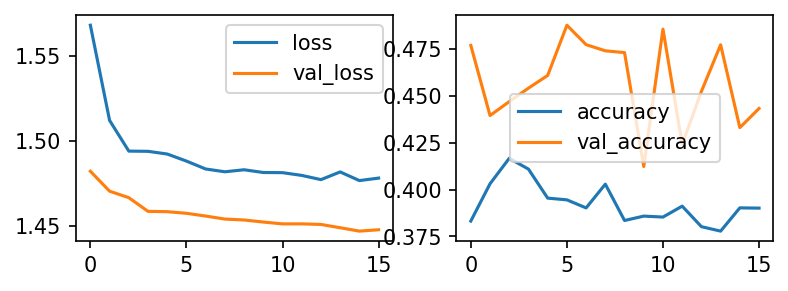

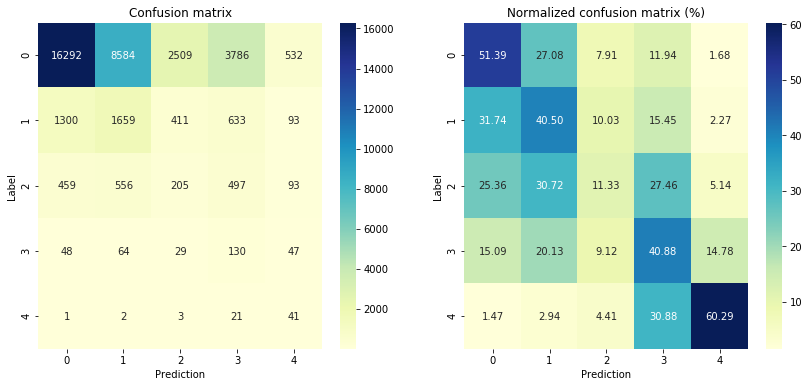

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
LR,0.510078,0.406738,0.151381,0.330189,0.676471,0.480642,0.370857,0.425750,5.689
DT,0.832508,0.147461,0.086188,0.037736,0.161765,0.715252,0.145221,0.430237,1.494
RF,0.597609,0.348633,0.056354,0.238994,0.705882,0.542177,0.287982,0.415079,4.035
MLP with weights,0.513895,0.405029,0.113260,0.408805,0.602941,0.482353,0.357146,0.419749,96.176


In [30]:
model = tf.keras.Sequential([
  layers.Dense(10, activation='relu',input_dim=X_train.shape[1]),

    #  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(5,activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
start =time.time()
Monitor_MLP = model.fit(X_train, y_train.values, callbacks=[es],validation_data = (X_val,y_val),
                        class_weight = cls_wgt,
                        verbose = 1, epochs = 50)
end = time.time()

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

# Show evolution of the training process
show_evolution(Monitor_MLP)

# get the evaluation metrics
result = get_accs(y_test.values,y_pred,True)
result['Training Time'] = np.round(end-start,3)
result.index = ['MLP with weights']
try:
    rsts.loc['MLP with weights'] = result
except:
    rsts = rsts.append(result)
rsts

### with initial weight

In [31]:
from tensorflow.keras import initializers

In [32]:
from tensorflow.keras.initializers import Zeros,RandomNormal

In [33]:
bias_zeros = initializers.Zeros()
bias_rn = initializers.RandomNormal(mean=0.0, stddev=0.005, seed=None)
bias_ru = initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
bias_tn = initializers.TruncatedNormal(mean=0., stddev=1.)
bias_ones = initializers.Ones()
bias_gn = initializers.GlorotNormal(seed=None)
bias_iden = initializers.Identity(gain=1.0)
biases = [bias_zeros, bias_rn, bias_ru, bias_tn,
          bias_ones, bias_gn, bias_iden]
bias_name = ['bias_zeros', 'bias_rn', 'bias_ru', 'bias_tn',
          'bias_ones', 'bias_gn', 'bias_iden']

In [34]:
def create_mlp_1(ini_bias):
    MLP = tf.keras.Sequential([
        keras.layers.Dense(10, 
                           activation='relu',
                           input_dim=X_train.shape[1],
                           bias_initializer=ini_bias
                          ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(5,activation='softmax')])
    MLP.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return MLP

In [35]:
def evaluation(model,monitor,time,name):
    # use the model to make predictions with the test data
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred,axis=1)
    

    # Show evolution of the training process
    show_evolution(monitor)

    # get the evaluation metrics
    result = get_accs(y_test.values,y_pred,False)
    result['Training Time'] = np.round(time,3)
    result.index = [name]
    return result

bias_zeros
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/50
121580/121580 [==============================] - 6s 53us/sample - loss: 1.5993 - accuracy: 0.4232 - val_loss: 1.5656 - val_accuracy: 0.4425
Epoch 2/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.5648 - accuracy: 0.4255 - val_loss: 1.5476 - val_accuracy: 0.4648
Epoch 3/50
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5381 - accuracy: 0.4205 - val_loss: 1.4905 - val_accuracy: 0.4379
Epoch 4/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.5220 - accuracy: 0.4080 - val_loss: 1.4686 - val_accuracy: 0.4701
Epoch 5/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.5084 - accuracy: 0.4180 - val_loss: 1.4602 - val_accuracy: 0.4457
Epoch 6/50
121580/121580 [==============================] - 6s 48us/sample - loss: 1.5056 - accuracy: 0.4195 - val_loss: 1.4623 - val

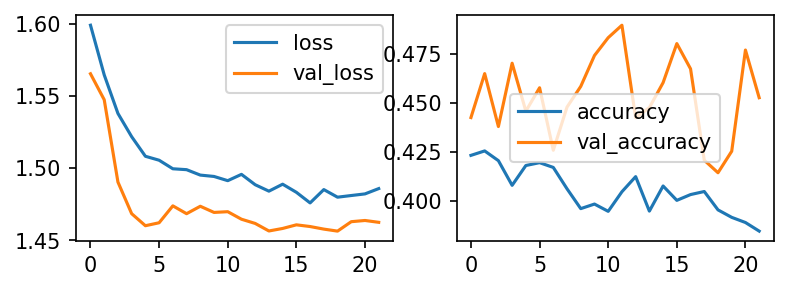

bias_rn
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/50
121580/121580 [==============================] - 6s 52us/sample - loss: 1.5789 - accuracy: 0.3755 - val_loss: 1.5312 - val_accuracy: 0.4736
Epoch 2/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.5170 - accuracy: 0.3813 - val_loss: 1.4744 - val_accuracy: 0.4558
Epoch 3/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.5045 - accuracy: 0.3944 - val_loss: 1.4720 - val_accuracy: 0.4295
Epoch 4/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.4974 - accuracy: 0.3703 - val_loss: 1.4669 - val_accuracy: 0.4421
Epoch 5/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.4944 - accuracy: 0.3793 - val_loss: 1.4650 - val_accuracy: 0.4754
Epoch 6/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.4844 - accuracy: 0.3894 - val_loss: 1.4637 - val_ac

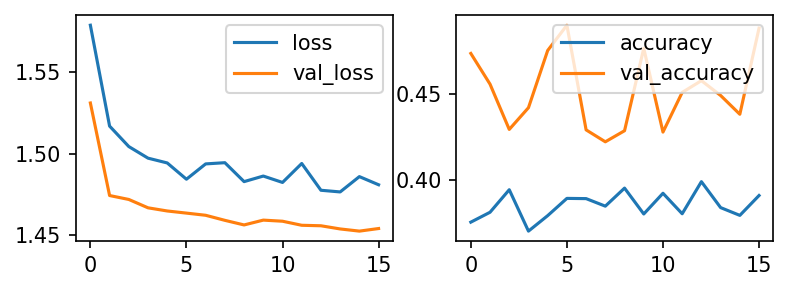

bias_ru
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/50
121580/121580 [==============================] - 6s 52us/sample - loss: 1.5641 - accuracy: 0.2082 - val_loss: 1.5046 - val_accuracy: 0.3219
Epoch 2/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.5182 - accuracy: 0.4122 - val_loss: 1.4836 - val_accuracy: 0.4475
Epoch 3/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.5046 - accuracy: 0.4376 - val_loss: 1.4661 - val_accuracy: 0.4194
Epoch 4/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.4981 - accuracy: 0.4727 - val_loss: 1.4617 - val_accuracy: 0.4345
Epoch 5/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.4944 - accuracy: 0.4647 - val_loss: 1.4642 - val_accuracy: 0.4474
Epoch 6/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.4908 - accuracy: 0.4070 - val_loss: 1.4638 - val_ac

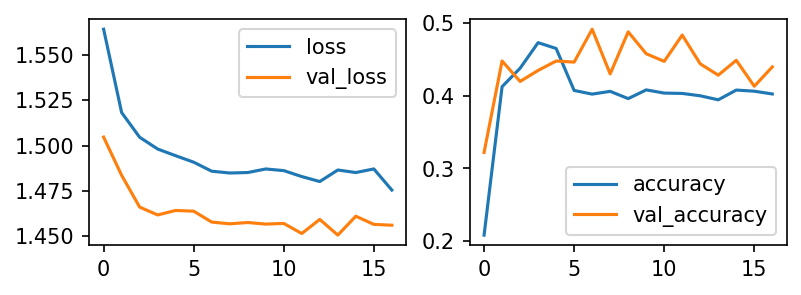

bias_tn
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/50
121580/121580 [==============================] - 6s 52us/sample - loss: 1.5607 - accuracy: 0.3563 - val_loss: 1.4930 - val_accuracy: 0.4567
Epoch 2/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.5211 - accuracy: 0.3968 - val_loss: 1.4657 - val_accuracy: 0.5351
Epoch 3/50
121580/121580 [==============================] - 6s 48us/sample - loss: 1.4966 - accuracy: 0.3968 - val_loss: 1.4592 - val_accuracy: 0.4723
Epoch 4/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.4929 - accuracy: 0.3953 - val_loss: 1.4570 - val_accuracy: 0.4770
Epoch 5/50
121580/121580 [==============================] - 6s 48us/sample - loss: 1.4944 - accuracy: 0.3978 - val_loss: 1.4583 - val_accuracy: 0.4684
Epoch 6/50
121580/121580 [==============================] - 6s 48us/sample - loss: 1.4851 - accuracy: 0.4003 - val_loss: 1.4587 - val_ac

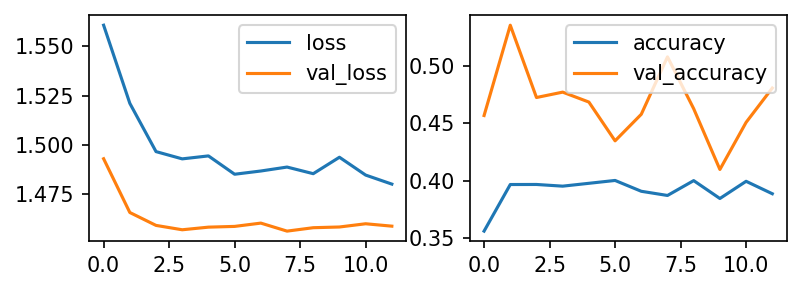

bias_ones
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/50
121580/121580 [==============================] - 6s 53us/sample - loss: 1.5963 - accuracy: 0.3627 - val_loss: 1.5503 - val_accuracy: 0.5127
Epoch 2/50
121580/121580 [==============================] - 6s 48us/sample - loss: 1.5600 - accuracy: 0.4242 - val_loss: 1.5277 - val_accuracy: 0.4706
Epoch 3/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.5557 - accuracy: 0.4299 - val_loss: 1.5193 - val_accuracy: 0.4641
Epoch 4/50
121580/121580 [==============================] - 6s 48us/sample - loss: 1.5467 - accuracy: 0.4318 - val_loss: 1.5015 - val_accuracy: 0.4753
Epoch 5/50
121580/121580 [==============================] - 6s 48us/sample - loss: 1.5327 - accuracy: 0.4277 - val_loss: 1.4821 - val_accuracy: 0.4574
Epoch 6/50
121580/121580 [==============================] - 6s 48us/sample - loss: 1.5199 - accuracy: 0.4236 - val_loss: 1.4823 - val_

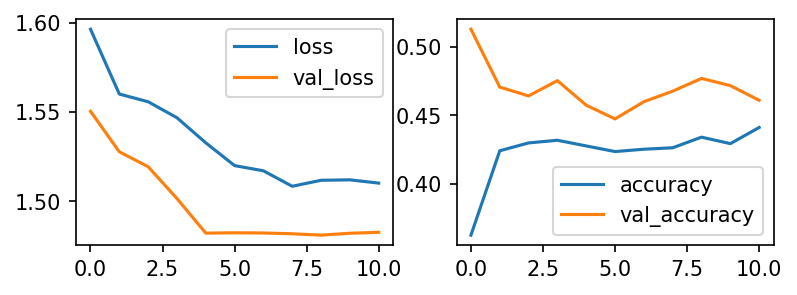

bias_gn
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/50
121580/121580 [==============================] - 6s 53us/sample - loss: 1.5831 - accuracy: 0.4027 - val_loss: 1.5400 - val_accuracy: 0.4922
Epoch 2/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.5343 - accuracy: 0.4290 - val_loss: 1.4725 - val_accuracy: 0.4601
Epoch 3/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.5040 - accuracy: 0.4299 - val_loss: 1.4707 - val_accuracy: 0.5155
Epoch 4/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.5003 - accuracy: 0.4364 - val_loss: 1.4707 - val_accuracy: 0.5205
Epoch 5/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.4987 - accuracy: 0.4319 - val_loss: 1.4638 - val_accuracy: 0.4817
Epoch 6/50
121580/121580 [==============================] - 6s 49us/sample - loss: 1.4970 - accuracy: 0.4084 - val_loss: 1.4652 - val_ac

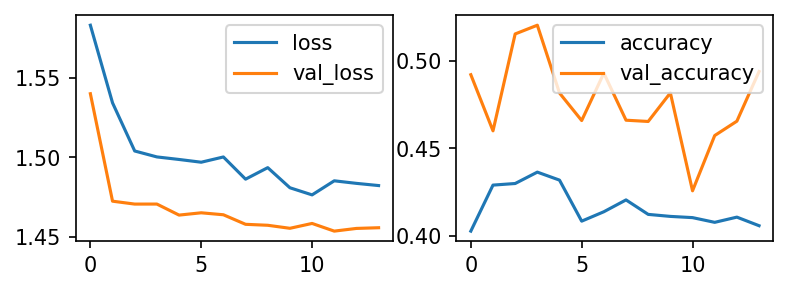

bias_iden
Identity matrix initializer can only be used for 2D matrices.


,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
bias_zeros,0.514809,0.439209,0.081215,0.383648,0.617647,0.485090,0.337074,0.411082,132.070
bias_rn,0.519951,0.407959,0.126519,0.355346,0.588235,0.487880,0.354640,0.421260,95.729
bias_ru,0.524682,0.393799,0.097790,0.289308,0.676471,0.488538,0.330685,0.409612,101.829
bias_tn,0.585497,0.390625,0.064641,0.166667,0.764706,0.536492,0.285120,0.410806,71.528
bias_ones,0.556383,0.342529,0.119890,0.518868,0.000000,0.511225,0.103462,0.307344,65.432
bias_gn,0.562723,0.286377,0.196133,0.305031,0.676471,0.513515,0.365490,0.439502,84.534


In [36]:
rsts = pd.DataFrame()
for bias, name in zip(biases,bias_name):
    print(name)
    try: 
        model = create_mlp_1(bias)
    except Exception as e: 
        print(e)
        continue
    start = time.time()
    monitor = model.fit(X_train, y_train, callbacks=[es],validation_data = (X_val,y_val),
                        class_weight = cls_wgt,
                        verbose = 1, epochs = 50)
    end= time.time()
    rsts = rsts.append(evaluation(model,monitor,end-start,name))
rsts

bias_random uniform produced the highest accuracy 0.4977
bias_zeros gave highest G-mean
bias_random uniform has potential to give us the highest balance between accuracy and g-mean

In [37]:
bias_rus = [initializers.RandomUniform(minval=-x, maxval=x, seed=None) for x in 1/10**(np.arange(2,7))]
ru_names = ['ru_'+ str(x) for x in 1/10**(np.arange(2,7))]

ru_0.01
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


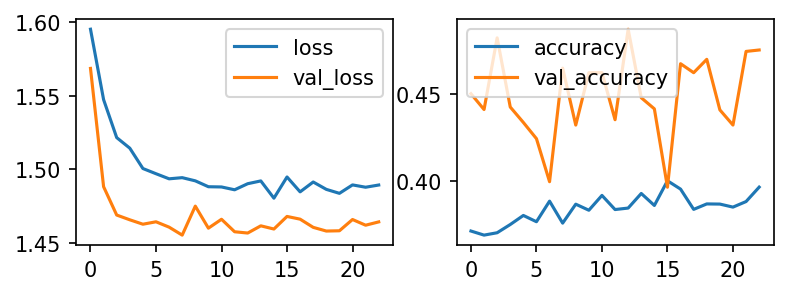

ru_0.001
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping


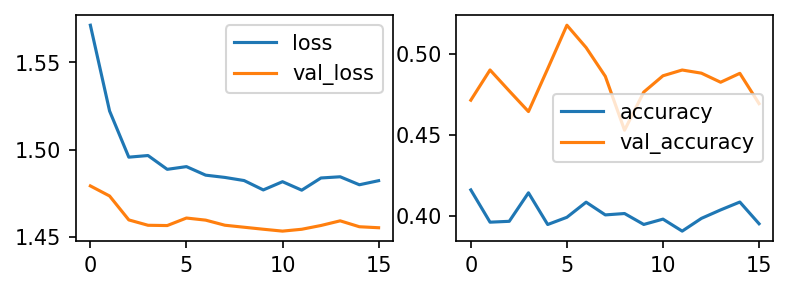

ru_0.0001
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


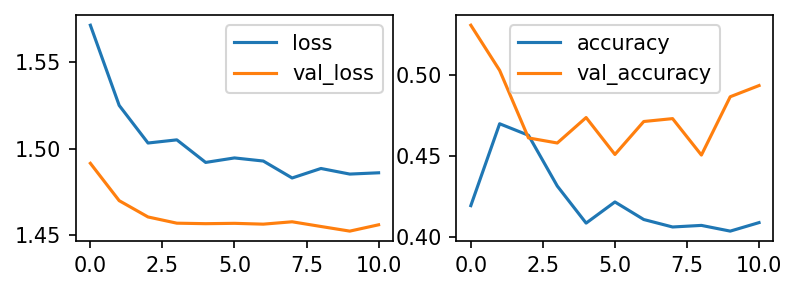

ru_1e-05
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping


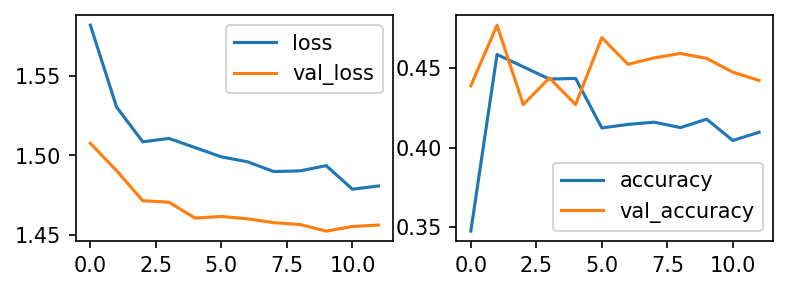

ru_1e-06
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping


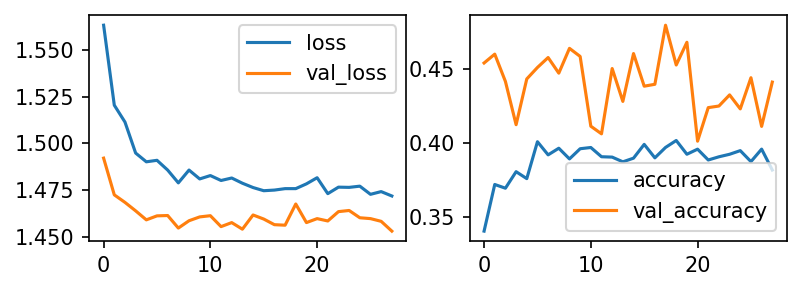

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
ru_0.01,0.512759,0.409668,0.139779,0.308176,0.632353,0.482379,0.356048,0.419214,133.444
ru_0.001,0.556698,0.350830,0.170166,0.242138,0.676471,0.513673,0.352517,0.433095,92.226
ru_0.0001,0.587168,0.212402,0.266851,0.135220,0.676471,0.527885,0.313831,0.420858,63.706
ru_1e-05,0.513453,0.365234,0.116575,0.474843,0.485294,0.478194,0.347093,0.412644,70.207
ru_1e-06,0.496483,0.433105,0.145304,0.229560,0.661765,0.470983,0.342985,0.406984,162.219


In [39]:
rsts = pd.DataFrame()
for bias, name in zip(bias_rus,ru_names):
    print(name)
    model = create_mlp_1(bias)
    start = time.time()
    monitor = model.fit(X_train, y_train, callbacks=[es],validation_data = (X_val,y_val),
                        class_weight = cls_wgt,
                        verbose = 0, epochs = 50)
    end= time.time()
    rsts = rsts.append(evaluation(model,monitor,end-start,name))
rsts

In [73]:
rsts[['Overall Accuracy','G-mean']].sum(axis=1)/2

ru_0.01      0.422158
ru_0.001     0.398276
ru_0.0001    0.407155
ru_1e-05     0.434984
ru_1e-06     0.414696
dtype: float64

Best: 0.493354	0.376613

### regularizers

In [40]:
from tensorflow.keras import regularizers

In [41]:
l1 = keras.regularizers.l1(0.0001)
l2 = keras.regularizers.l2(0.0001)
l12 = keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)
regus = [None,l1,l2,l12]
regu_names = ['None', "l1",'l2','l12']

In [42]:
ini_bias = initializers.RandomUniform(minval=-1e-05, maxval=1e-05, seed=None)
def create_mlp_2(r1,r2):
    MLP = tf.keras.Sequential([
        keras.layers.Dense(10, 
                           activation='relu',
                           input_dim=X_train.shape[1],
                           bias_initializer=ini_bias,
                           activity_regularizer=r1
                          ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(5,activation='softmax',
                          activity_regularizer=r2)])
    MLP.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return MLP

Re None and None
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


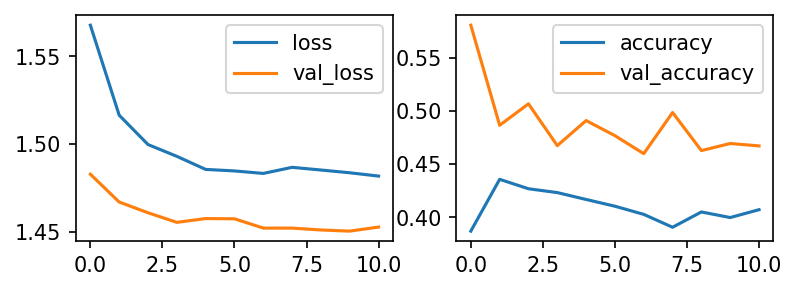

Re None and l1
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping


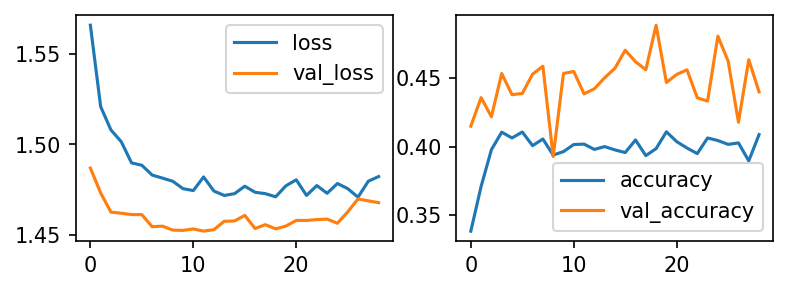

Re None and l2
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


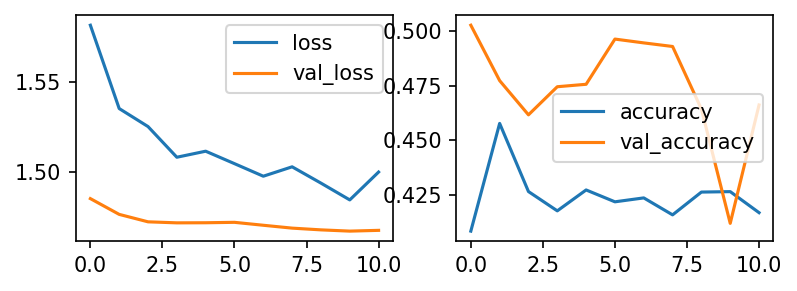

Re None and l12
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


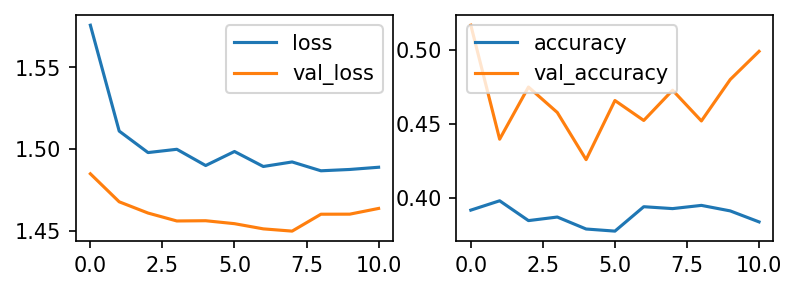

Re l1 and None
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping


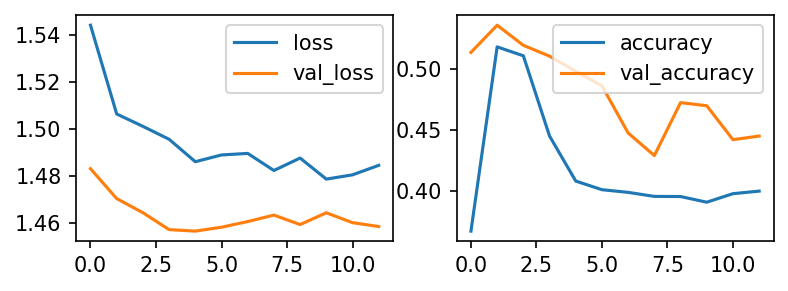

Re l1 and l1
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping


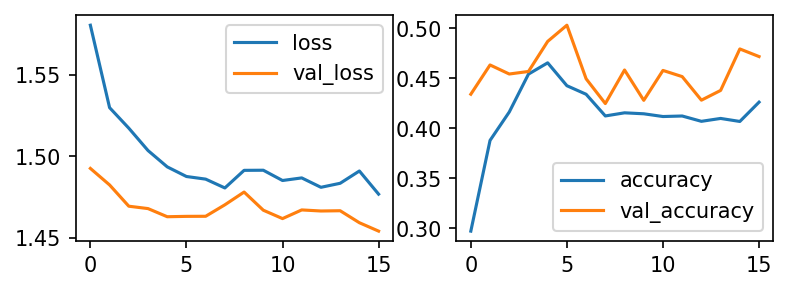

Re l1 and l2
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


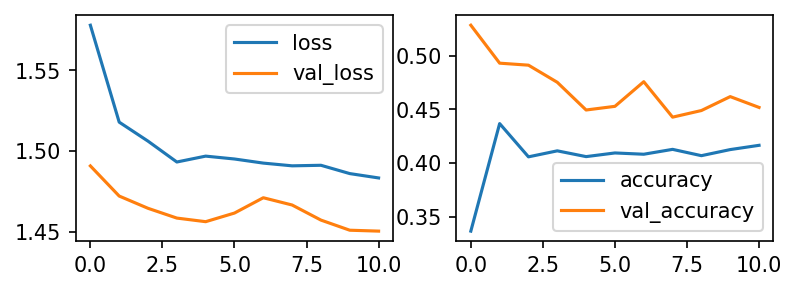

Re l1 and l12
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping


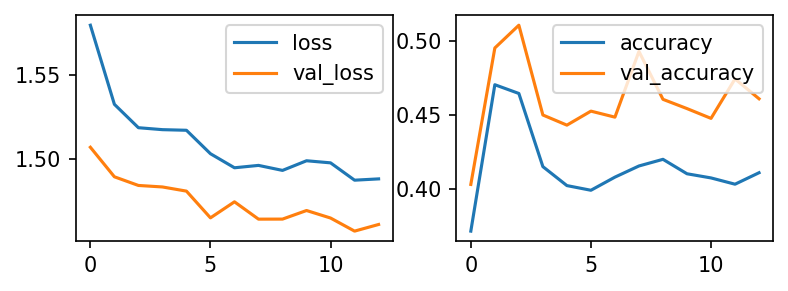

Re l2 and None
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping


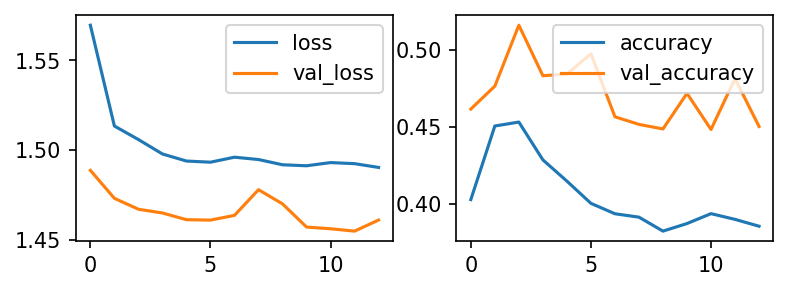

Re l2 and l1
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping


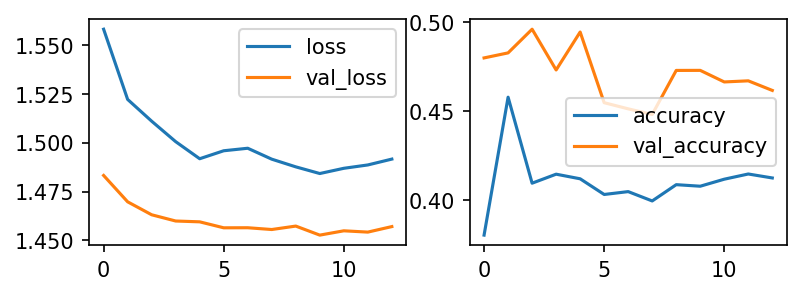

Re l2 and l2
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


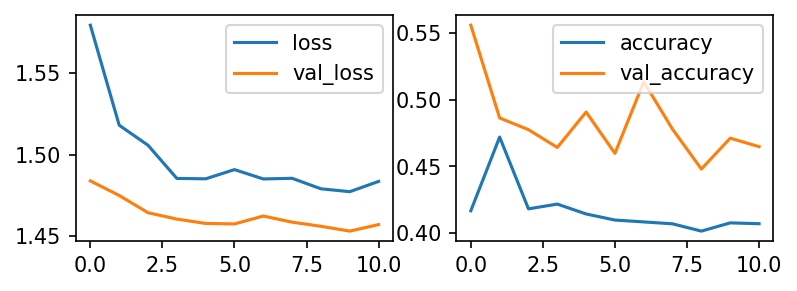

Re l2 and l12
  ...
    to  
  ['...']
  ...
    to  
  ['...']


In [ ]:
rsts = pd.DataFrame()
for regu1, name1 in zip(regus,regu_names):
    for regu2, name2 in zip(regus,regu_names):
        name = 'Re ' + name1 +' and ' +name2
        print(name)
        model = create_mlp_2(regu1,regu2)
        start = time.time()
        monitor = model.fit(X_train, y_train, callbacks=[es],validation_data = (X_val,y_val),
                            class_weight = cls_wgt,
                            verbose = 0, epochs = 50)
        end= time.time()
        rsts = rsts.append(evaluation(model,monitor,end-start,name))
rsts        


In [45]:
rsts['Avg_Pfm'] = rsts[['Overall Accuracy','G-mean']].sum(axis=1)/2
rsts

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Training Time,Avg_Pfm
Re None and None,0.498817,0.267578,0.309945,0.295597,0.661765,0.463482,0.381607,28.670,0.422544
Re None and l1,0.482005,0.474365,0.120442,0.248428,0.676471,0.462350,0.341254,29.720,0.401802
Re None and l2,0.472984,0.451172,0.192265,0.235849,0.705882,0.455692,0.368885,29.723,0.412288
Re None and l12,0.467306,0.499756,0.123757,0.220126,0.750000,0.452875,0.343346,29.895,0.398111
Re l1 and None,0.477147,0.465088,0.112707,0.254717,0.720588,0.457060,0.340704,29.990,0.398882
Re l1 and l1,0.491026,0.431641,0.158564,0.210692,0.661765,0.466746,0.342103,30.591,0.404424
Re l1 and l2,0.480995,0.473633,0.101657,0.317610,0.632353,0.461034,0.341598,30.308,0.401316
Re l1 and l12,0.531275,0.373779,0.212707,0.276730,0.661765,0.497223,0.378177,30.879,0.437700
Re l2 and None,0.455194,0.452393,0.170718,0.364780,0.602941,0.440847,0.378146,29.671,0.409497
Re l2 and l1,0.509163,0.379639,0.156354,0.566038,0.323529,0.478537,0.353687,30.255,0.416112


In [42]:
Best_perf = pd.DataFrame() 

In [54]:
rsts.sort_values('Avg_Pfm',ascending=False).iloc[0]

Class 0              0.531275
Class 1              0.373779
Class 2              0.212707
Class 3              0.276730
Class 4              0.661765
Overall Accuracy     0.497223
G-mean               0.378177
Training Time       30.879000
Avg_Pfm              0.437700
Name: Re l1 and l12, dtype: float64

In [55]:
Best_perf = Best_perf.append(rsts.sort_values('Avg_Pfm',ascending=False).iloc[0])
Best_perf

,Avg_Pfm,Class 0,Class 1,Class 2,Class 3,Class 4,G-mean,Overall Accuracy,Training Time
Re l1 and l12,0.4377,0.531275,0.373779,0.212707,0.27673,0.661765,0.378177,0.497223,30.879


## activation

In [56]:
activations = ['relu', 'sigmoid', 'tanh', 'selu','elu','exponential']

In [57]:
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.regularizers import l1,l1_l2

In [ ]:
def create_mlp_2(acti):
  MLP = tf.keras.Sequential([
    keras.layers.Dense(5, activation=acti,input_dim=X_train.shape[1],bias_initializer=Zeros()),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activity_regularizer=l1_l2(0.0001,0.0001))])
  MLP.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return MLP

In [59]:
1e-4

0.0001

In [60]:
ini_bias = initializers.RandomUniform(minval=-1e-05, maxval=1e-05, seed=None)
def create_mlp_2(acti):
    MLP = tf.keras.Sequential([
        keras.layers.Dense(10, 
                           activation=acti, # tuning parameter
                           input_dim=X_train.shape[1],
                           bias_initializer=ini_bias,
                           activity_regularizer=l1(1e-4)
                          ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(5,activation='softmax',
                          activity_regularizer=l1_l2(1e-4,1e-4))])
    MLP.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return MLP

relu
  ...
    to  
  ['...']
  ...
    to  
  ['...']


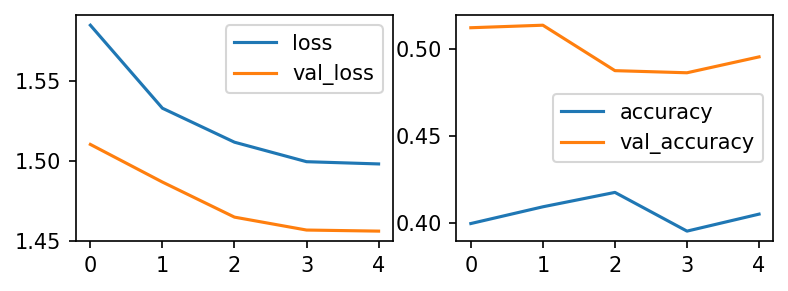

sigmoid
  ...
    to  
  ['...']
  ...
    to  
  ['...']


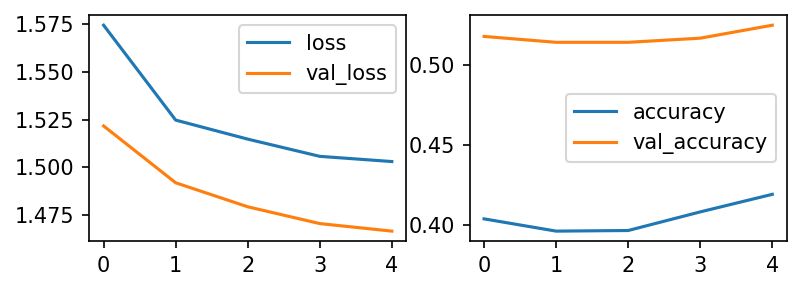

tanh
  ...
    to  
  ['...']
  ...
    to  
  ['...']


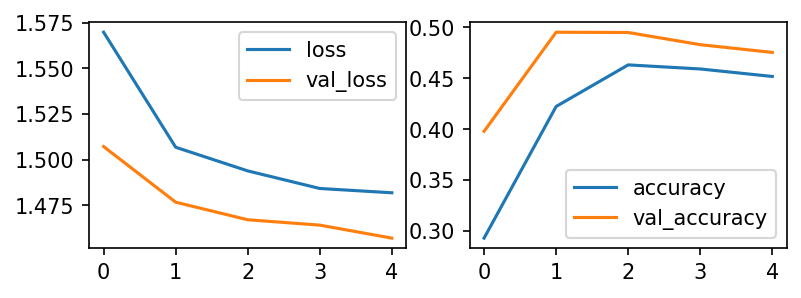

selu
  ...
    to  
  ['...']
  ...
    to  
  ['...']


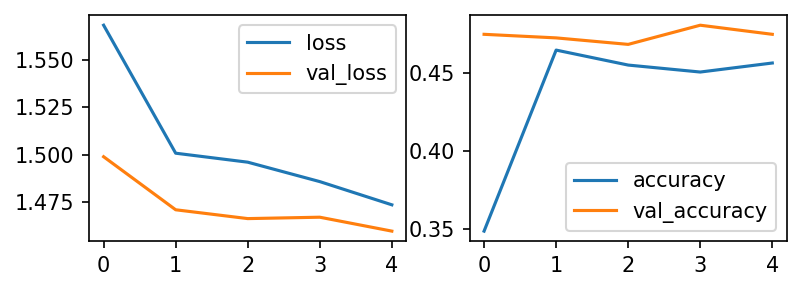

elu
  ...
    to  
  ['...']
  ...
    to  
  ['...']


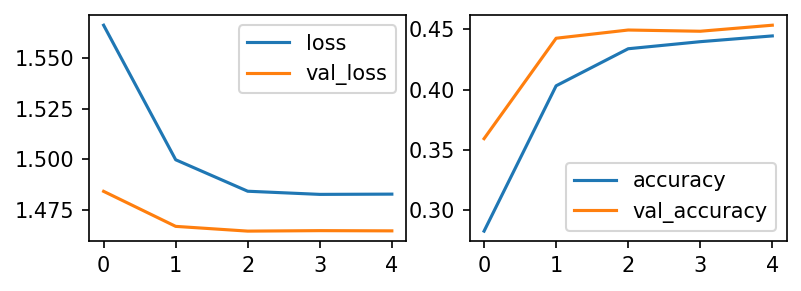

exponential
  ...
    to  
  ['...']
  ...
    to  
  ['...']


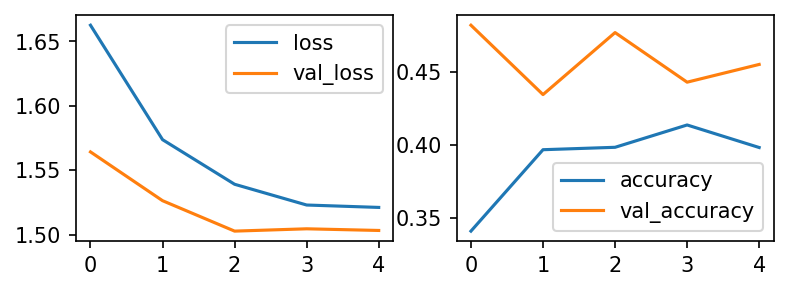

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
relu,0.522663,0.403076,0.201105,0.242138,0.676471,0.492381,0.370057,0.431219,30.578
sigmoid,0.565719,0.375488,0.123204,0.220126,0.779412,0.521621,0.339197,0.430409,30.713
tanh,0.502035,0.432373,0.132044,0.172956,0.764706,0.474615,0.327905,0.401260,30.438
selu,0.496798,0.423584,0.149171,0.257862,0.691176,0.470694,0.354451,0.412572,30.378
elu,0.465634,0.449219,0.143094,0.367925,0.617647,0.447954,0.368574,0.408264,30.623
exponential,0.465981,0.444580,0.178453,0.462264,0.338235,0.449717,0.356772,0.403244,30.503


In [61]:
rsts = pd.DataFrame()
for acti in activations:
    print(acti)
    model = create_mlp_2(acti)
    start = time.time()
    monitor = model.fit(X_train, y_train, callbacks=[es],validation_data = (X_val,y_val),
                        class_weight = cls_wgt,
                        verbose = 0, epochs = 5)
    end= time.time()
    rsts = rsts.append(evaluation(model,monitor,end-start,acti))
rsts        


In [62]:
Best_perf = Best_perf.append(rsts.sort_values('Avg_Pfm',ascending=False).iloc[0])
Best_perf

,Avg_Pfm,Class 0,Class 1,Class 2,Class 3,Class 4,G-mean,Overall Accuracy,Training Time
Re l1 and l12,0.437700,0.531275,0.373779,0.212707,0.276730,0.661765,0.378177,0.497223,30.879
relu,0.431219,0.522663,0.403076,0.201105,0.242138,0.676471,0.370057,0.492381,30.578


## kernel_initializer

In [ ]:
def create_mlp_2(ker_ini):
  MLP = tf.keras.Sequential([
    keras.layers.Dense(5, activation='selu',input_dim=X_train.shape[1],bias_initializer=Zeros(),
                       kernel_initializer=ker_ini),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activity_regularizer=l1_l2(0.0001,0.0001))])
  MLP.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return MLP

In [63]:
def create_mlp_2(ker_ini):
    MLP = tf.keras.Sequential([
        keras.layers.Dense(10, 
                           activation='relu', # tuning parameter
                           input_dim=X_train.shape[1],
                           bias_initializer=ini_bias,
                           activity_regularizer=l1(1e-4),
                           kernel_initializer=ker_ini
                          ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(5,activation='softmax',
                          activity_regularizer=l1_l2(1e-4,1e-4))])
    MLP.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return MLP

bias_zeros
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 55us/sample - loss: 1.5613 - accuracy: 0.3520 - val_loss: 1.4908 - val_accuracy: 0.5219
Epoch 2/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5231 - accuracy: 0.4106 - val_loss: 1.4754 - val_accuracy: 0.5009
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5226 - accuracy: 0.4062 - val_loss: 1.4690 - val_accuracy: 0.4447
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5168 - accuracy: 0.4059 - val_loss: 1.4631 - val_accuracy: 0.4762
Epoch 5/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.5103 - accuracy: 0.3971 - val_loss: 1.4687 - val_accuracy: 0.4681


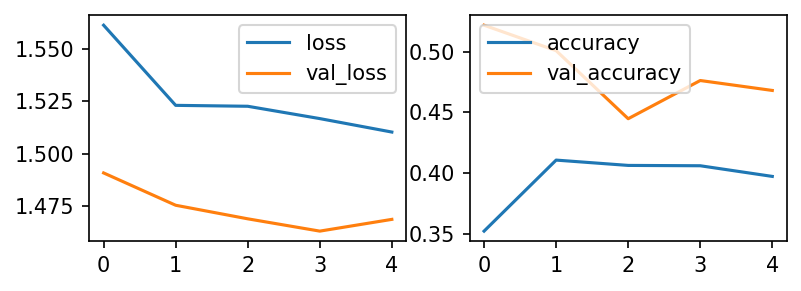

bias_rn
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 60us/sample - loss: 1.5397 - accuracy: 0.3800 - val_loss: 1.4788 - val_accuracy: 0.4839
Epoch 2/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5012 - accuracy: 0.4949 - val_loss: 1.4703 - val_accuracy: 0.4707
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4959 - accuracy: 0.4955 - val_loss: 1.4573 - val_accuracy: 0.4951
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4836 - accuracy: 0.4926 - val_loss: 1.4565 - val_accuracy: 0.4975
Epoch 5/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4901 - accuracy: 0.4911 - val_loss: 1.4556 - val_accuracy: 0.4820


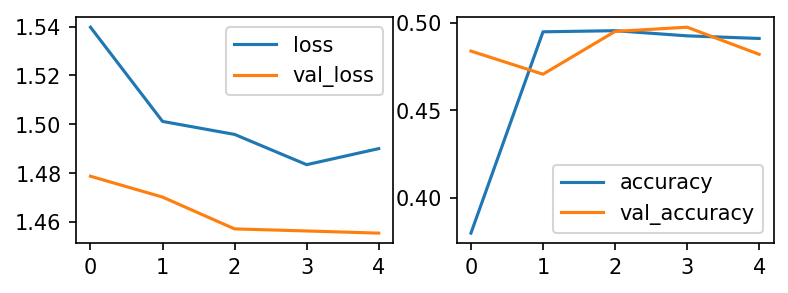

bias_ru
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 56us/sample - loss: 1.5407 - accuracy: 0.4202 - val_loss: 1.4738 - val_accuracy: 0.4948
Epoch 2/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5074 - accuracy: 0.4254 - val_loss: 1.4651 - val_accuracy: 0.4949
Epoch 3/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5025 - accuracy: 0.4251 - val_loss: 1.4590 - val_accuracy: 0.4952
Epoch 4/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.5012 - accuracy: 0.4111 - val_loss: 1.4529 - val_accuracy: 0.4454
Epoch 5/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.4920 - accuracy: 0.4166 - val_loss: 1.4603 - val_accuracy: 0.4590


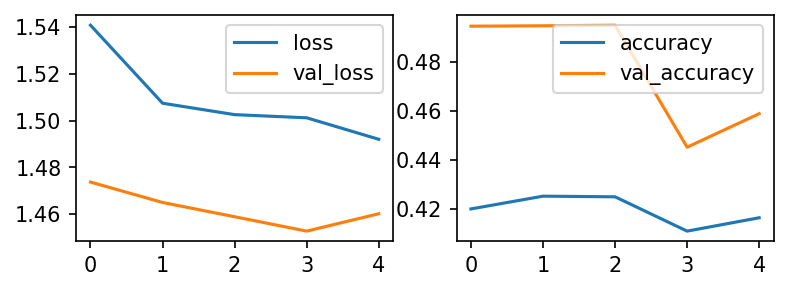

bias_tn
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 55us/sample - loss: 1.6344 - accuracy: 0.3235 - val_loss: 1.5718 - val_accuracy: 0.3326
Epoch 2/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5817 - accuracy: 0.3145 - val_loss: 1.5369 - val_accuracy: 0.5390
Epoch 3/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5558 - accuracy: 0.3636 - val_loss: 1.5100 - val_accuracy: 0.5052
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5375 - accuracy: 0.3481 - val_loss: 1.5071 - val_accuracy: 0.4406
Epoch 5/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5228 - accuracy: 0.3536 - val_loss: 1.5163 - val_accuracy: 0.4320


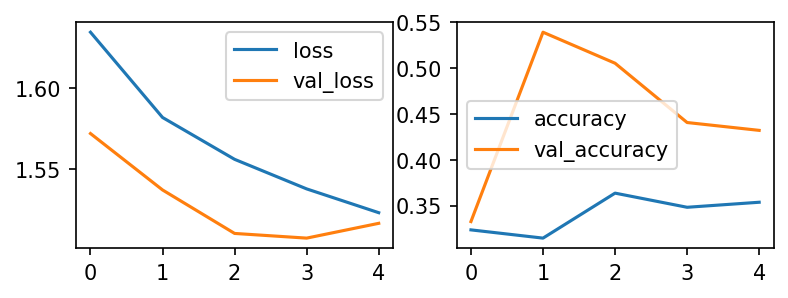

bias_ones
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 55us/sample - loss: 1.6386 - accuracy: 0.5975 - val_loss: 1.5189 - val_accuracy: 0.5896
Epoch 2/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5924 - accuracy: 0.5980 - val_loss: 1.5186 - val_accuracy: 0.6587
Epoch 3/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5733 - accuracy: 0.5732 - val_loss: 1.5233 - val_accuracy: 0.5317
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5579 - accuracy: 0.5709 - val_loss: 1.5167 - val_accuracy: 0.6684
Epoch 5/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5431 - accuracy: 0.6006 - val_loss: 1.5072 - val_accuracy: 0.6200


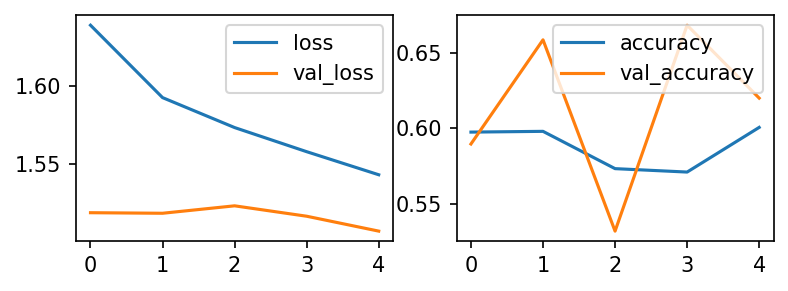

bias_gn
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 54us/sample - loss: 1.5948 - accuracy: 0.3453 - val_loss: 1.5082 - val_accuracy: 0.4599
Epoch 2/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5207 - accuracy: 0.3588 - val_loss: 1.4821 - val_accuracy: 0.4420
Epoch 3/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5130 - accuracy: 0.3775 - val_loss: 1.4743 - val_accuracy: 0.4499
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5048 - accuracy: 0.3914 - val_loss: 1.4675 - val_accuracy: 0.4777
Epoch 5/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5066 - accuracy: 0.4202 - val_loss: 1.4610 - val_accuracy: 0.4907


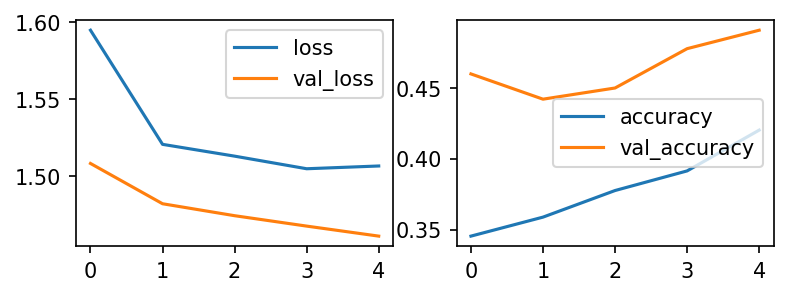

bias_iden
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 55us/sample - loss: 1.5390 - accuracy: 0.4125 - val_loss: 1.4814 - val_accuracy: 0.4877
Epoch 2/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5037 - accuracy: 0.4584 - val_loss: 1.4651 - val_accuracy: 0.4700
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4974 - accuracy: 0.4151 - val_loss: 1.4626 - val_accuracy: 0.4714
Epoch 4/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.4879 - accuracy: 0.4074 - val_loss: 1.4609 - val_accuracy: 0.4970
Epoch 5/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4929 - accuracy: 0.4292 - val_loss: 1.4611 - val_accuracy: 0.4479


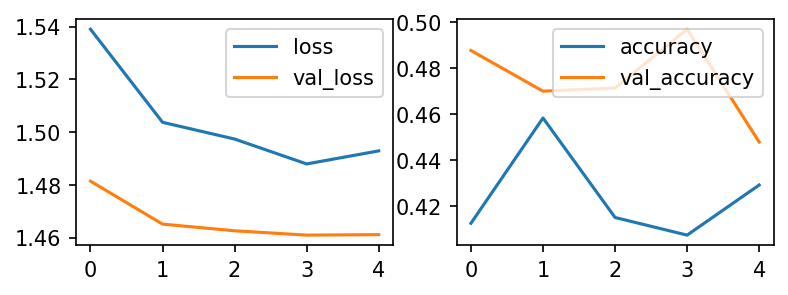

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
bias_zeros,0.492035,0.398682,0.175691,0.198113,0.676471,0.464772,0.341120,0.402946,31.721
bias_rn,0.500142,0.464111,0.162983,0.207547,0.735294,0.478168,0.356687,0.417428,32.177
bias_ru,0.477242,0.433350,0.129834,0.327044,0.617647,0.454955,0.352259,0.403607,31.490
bias_tn,0.440400,0.494141,0.138674,0.172956,0.602941,0.429872,0.315923,0.372897,31.483
bias_ones,0.703814,0.181396,0.228729,0.000000,0.764706,0.619081,0.117430,0.368256,31.231
bias_gn,0.519036,0.358643,0.183978,0.245283,0.764706,0.483932,0.364382,0.424157,31.075
bias_iden,0.452386,0.516357,0.117680,0.201258,0.720588,0.441716,0.331223,0.386469,31.555


In [65]:
rsts = pd.DataFrame()
for bias, name in zip(biases,bias_name):
    print(name)
    try: 
        model = create_mlp_2(bias)
    except Exception as e: 
        print(e)
        continue
    start = time.time()
    monitor = model.fit(X_train, y_train, callbacks=[es],validation_data = (X_val,y_val),
                        class_weight = cls_wgt,
                        verbose = 1, epochs = 5)
    end= time.time()
    rsts = rsts.append(evaluation(model,monitor,end-start,name))
rsts

## loss function 1

In [30]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy, KLDivergence,Poisson

In [37]:
scc1 = SparseCategoricalCrossentropy(from_logits=True)
scc2 = SparseCategoricalCrossentropy()
kld = KLDivergence()
poi = Poisson()
losses = [scc1, scc2, kld, poi]
loss_names = ['scc1', 'scc2', 'kld', 'poi']

In [32]:
def create_mlp_2(los_fun):
    MLP = tf.keras.Sequential([
        keras.layers.Dense(10, 
                           activation='relu', 
                           input_dim=X_train.shape[1],
                           bias_initializer=RandomUniform(minval=-1e-05, maxval=1e-05, seed=None),
                           activity_regularizer=l1(1e-4),
                          ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(5,activation='softmax',
                          activity_regularizer=l1_l2(1e-4,1e-4))])
    MLP.compile(optimizer='adam',
                loss=los_fun, # tuning parameter
                metrics=['accuracy'])
    return MLP

scc1
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 57us/sample - loss: 1.5983 - accuracy: 0.3459 - val_loss: 1.5677 - val_accuracy: 0.5114
Epoch 2/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.5436 - accuracy: 0.4097 - val_loss: 1.4897 - val_accuracy: 0.5185
Epoch 3/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.5277 - accuracy: 0.4013 - val_loss: 1.4747 - val_accuracy: 0.4881
Epoch 4/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.5257 - accuracy: 0.3856 - val_loss: 1.4821 - val_accuracy: 0.4472
Epoch 5/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.5089 - accuracy: 0.3994 - val_loss: 1.4820 - val_accuracy: 0.4604


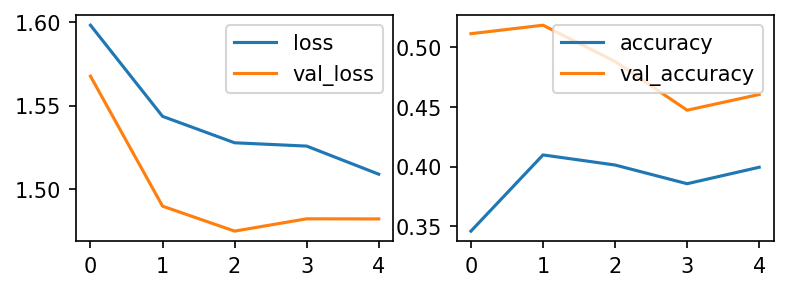

scc2
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 58us/sample - loss: 1.8289 - accuracy: 0.3216 - val_loss: 1.4292 - val_accuracy: 0.4281
Epoch 2/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.4730 - accuracy: 0.3266 - val_loss: 1.3642 - val_accuracy: 0.4573
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4222 - accuracy: 0.4129 - val_loss: 1.3560 - val_accuracy: 0.4348
Epoch 4/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.4057 - accuracy: 0.4422 - val_loss: 1.3304 - val_accuracy: 0.4925
Epoch 5/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.3951 - accuracy: 0.4431 - val_loss: 1.3614 - val_accuracy: 0.4825


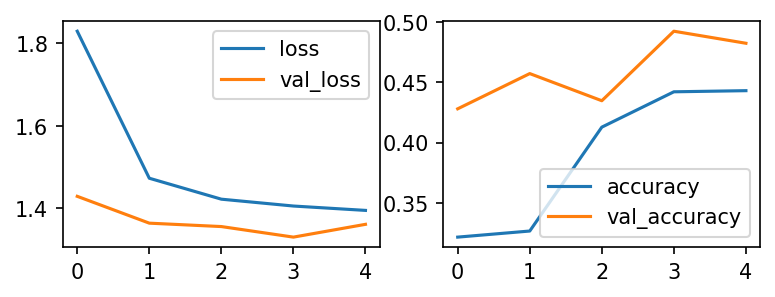

kld
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 59us/sample - loss: 7.2838 - accuracy: 0.1829 - val_loss: 6.4433 - val_accuracy: 0.1624
Epoch 2/5
121580/121580 [==============================] - 6s 53us/sample - loss: 6.4714 - accuracy: 0.4352 - val_loss: 6.4296 - val_accuracy: 0.5504
Epoch 3/5
121580/121580 [==============================] - 7s 54us/sample - loss: 6.4578 - accuracy: 0.5538 - val_loss: 6.4286 - val_accuracy: 0.7839
Epoch 4/5
121580/121580 [==============================] - 7s 54us/sample - loss: 6.4580 - accuracy: 0.3802 - val_loss: 6.4284 - val_accuracy: 0.0266
Epoch 5/5
121580/121580 [==============================] - 7s 54us/sample - loss: 6.4541 - accuracy: 0.4277 - val_loss: 6.4284 - val_accuracy: 0.0107


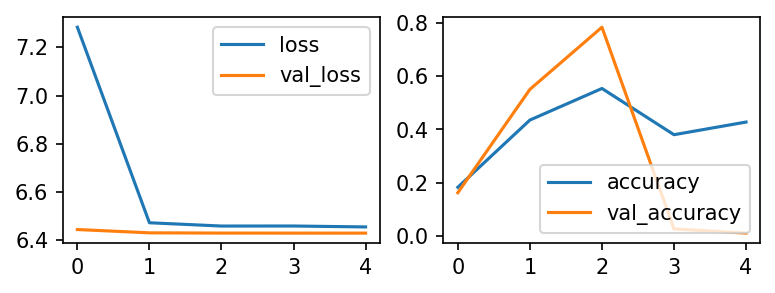

poi
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 57us/sample - loss: 4.1161 - accuracy: 0.2782 - val_loss: 3.4419 - val_accuracy: 0.1304
Epoch 2/5
121580/121580 [==============================] - 6s 52us/sample - loss: 3.4547 - accuracy: 0.2306 - val_loss: 3.4137 - val_accuracy: 0.0880
Epoch 3/5
121580/121580 [==============================] - 6s 52us/sample - loss: 3.4310 - accuracy: 0.1993 - val_loss: 3.4120 - val_accuracy: 0.0615
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 3.4223 - accuracy: 0.1003 - val_loss: 3.4117 - val_accuracy: 0.0561
Epoch 5/5
121580/121580 [==============================] - 6s 51us/sample - loss: 3.4259 - accuracy: 0.1118 - val_loss: 3.4116 - val_accuracy: 0.0309


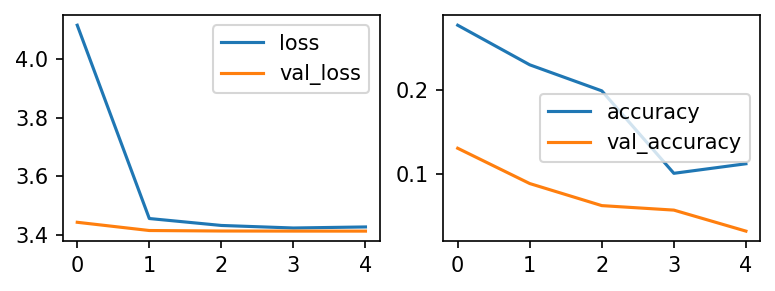

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
scc1,0.491562,0.425781,0.089503,0.424528,0.617647,0.464982,0.345342,0.405162,32.224
scc2,0.541526,0.114258,0.237017,0.336478,0.764706,0.479642,0.327602,0.403622,31.531
kld,0.012081,0.985107,0.002762,0.000000,0.000000,0.116410,0.008005,0.062208,33.442
poi,0.034287,0.020020,0.944199,0.012579,0.000000,0.075852,0.024113,0.049983,32.125


In [38]:
rsts = pd.DataFrame()
for func, name in zip(losses,loss_names):
    print(name)
    try: 
        model = create_mlp_2(func)
    except Exception as e: 
        print(e)
        continue
    start = time.time()
    monitor = model.fit(X_train, y_train, callbacks=[es],validation_data = (X_val,y_val),
                        class_weight = cls_wgt,
                        verbose = 1, epochs = 5)
    end= time.time()
    rsts = rsts.append(evaluation(model,monitor,end-start,name))  
rsts

## Optimizer

In [50]:
from tensorflow.keras.optimizers import Adam

### Learning rate

In [56]:
adams = [Adam(learning_rate=1/10**x) for x in range(2,6)]
names = ['lr #{}'.format(1/10**x) for x in range(2,6)]
adams, names

([<tensorflow.python.keras.optimizer_v2.adam.Adam at 0x2b73813a3278>,
 ['lr #0.01', 'lr #0.001', 'lr #0.0001', 'lr #1e-05'])

In [60]:
def create_mlp_2(opti):
    MLP = tf.keras.Sequential([
        keras.layers.Dense(10, 
                           activation='relu', 
                           input_dim=X_train.shape[1],
                           bias_initializer=RandomUniform(minval=-1e-05, maxval=1e-05, seed=None),
                           activity_regularizer=l1(1e-4),
                          ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(5,
                           activation='softmax',
                          activity_regularizer=l1_l2(1e-4,1e-4))])
    MLP.compile(optimizer=opti, # tuning paramete
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return MLP

lr #0.01
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 56us/sample - loss: 1.5883 - accuracy: 0.4116 - val_loss: 1.5873 - val_accuracy: 0.5901
Epoch 2/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5844 - accuracy: 0.4250 - val_loss: 1.5914 - val_accuracy: 0.5060
Epoch 3/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5768 - accuracy: 0.3910 - val_loss: 1.6105 - val_accuracy: 0.4278
Epoch 4/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5901 - accuracy: 0.4371 - val_loss: 1.6222 - val_accuracy: 0.5024
Epoch 5/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5966 - accuracy: 0.4750 - val_loss: 1.6118 - val_accuracy: 0.6359


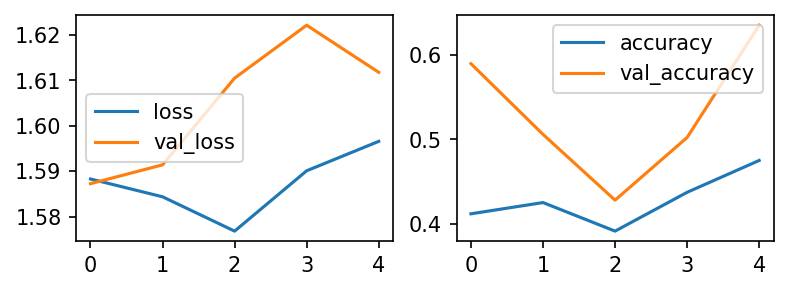

lr #0.001
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 55us/sample - loss: 1.5999 - accuracy: 0.3823 - val_loss: 1.5713 - val_accuracy: 0.5185
Epoch 2/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5575 - accuracy: 0.5168 - val_loss: 1.5437 - val_accuracy: 0.4745
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5172 - accuracy: 0.5050 - val_loss: 1.4767 - val_accuracy: 0.4809
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5023 - accuracy: 0.4946 - val_loss: 1.4783 - val_accuracy: 0.4760
Epoch 5/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4992 - accuracy: 0.4881 - val_loss: 1.4752 - val_accuracy: 0.4756


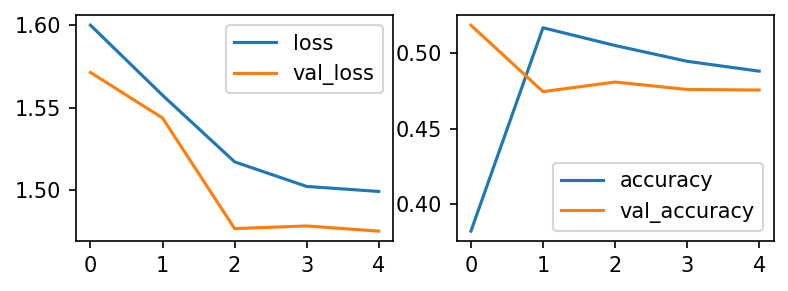

lr #0.0001
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 55us/sample - loss: 1.6419 - accuracy: 0.2779 - val_loss: 1.6222 - val_accuracy: 0.3589
Epoch 2/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.6315 - accuracy: 0.2801 - val_loss: 1.6097 - val_accuracy: 0.3608
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.6158 - accuracy: 0.2981 - val_loss: 1.6003 - val_accuracy: 0.3710
Epoch 4/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.6093 - accuracy: 0.3115 - val_loss: 1.5915 - val_accuracy: 0.3854
Epoch 5/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5932 - accuracy: 0.3416 - val_loss: 1.5834 - val_accuracy: 0.3936


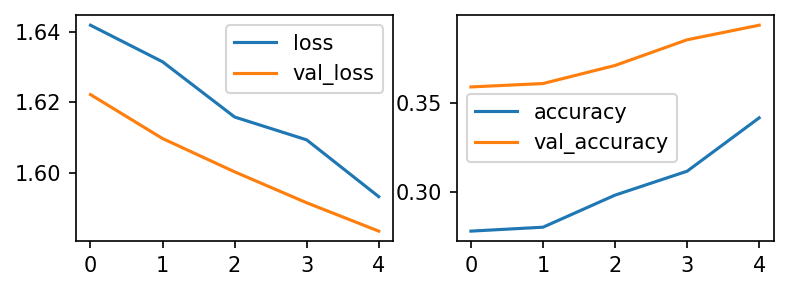

lr #1e-05
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 55us/sample - loss: 1.6495 - accuracy: 0.4000 - val_loss: 1.6420 - val_accuracy: 0.5093
Epoch 2/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.6385 - accuracy: 0.3923 - val_loss: 1.6387 - val_accuracy: 0.5102
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.6433 - accuracy: 0.3942 - val_loss: 1.6358 - val_accuracy: 0.5127
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.6325 - accuracy: 0.3967 - val_loss: 1.6324 - val_accuracy: 0.5139
Epoch 5/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.6336 - accuracy: 0.3979 - val_loss: 1.6295 - val_accuracy: 0.5161


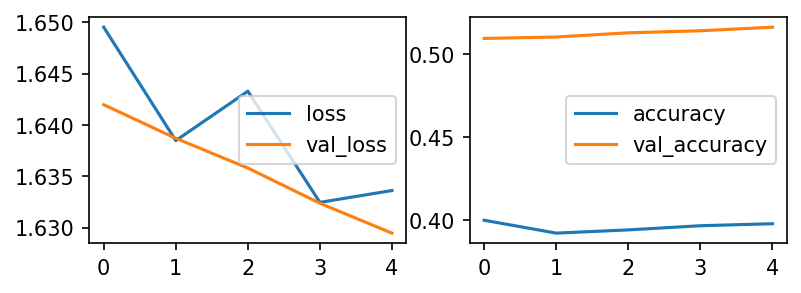

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
lr #0.01,0.715831,0.322754,0.136464,0.254717,0.058824,0.640821,0.216203,0.428512,31.407
lr #0.001,0.505914,0.402344,0.165193,0.342767,0.588235,0.477300,0.368335,0.422818,31.645
lr #0.0001,0.420843,0.336670,0.091713,0.481132,0.029412,0.395894,0.179023,0.287458,31.399
lr #1e-05,0.601205,0.069092,0.018232,0.232704,0.117647,0.512120,0.115700,0.313910,31.346


In [62]:
rsts = pd.DataFrame()
for optimizer, name in zip(adams,names):
    print(name)
    try: 
        model = create_mlp_2(optimizer)
    except Exception as e: 
        print(e)
        continue
    start = time.time()
    monitor = model.fit(X_train, y_train.values, callbacks=[es],validation_data = (X_val,y_val),
                        class_weight = cls_wgt,
                        batch_size = 32,
                        verbose = 1, epochs = 5)
    end= time.time()
    rsts = rsts.append(evaluation(model,monitor,end-start,name))  
rsts

### Epsilon

In [64]:
rang = range(6,10)
adams = [Adam(learning_rate=0.001, epsilon =1/10**x) for x in rang]
names = ['epsilon #{}'.format(1/10**x) for x in rang]
adams, names

([<tensorflow.python.keras.optimizer_v2.adam.Adam at 0x2b73813d2400>,
 ['epsilon #1e-06', 'epsilon #1e-07', 'epsilon #1e-08', 'epsilon #1e-09'])

epsilon #1e-06
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 55us/sample - loss: 1.5770 - accuracy: 0.3393 - val_loss: 1.5045 - val_accuracy: 0.4683
Epoch 2/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5240 - accuracy: 0.4849 - val_loss: 1.4714 - val_accuracy: 0.4792
Epoch 3/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5046 - accuracy: 0.5042 - val_loss: 1.4691 - val_accuracy: 0.4509
Epoch 4/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5035 - accuracy: 0.4284 - val_loss: 1.4632 - val_accuracy: 0.4362
Epoch 5/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4922 - accuracy: 0.4462 - val_loss: 1.4549 - val_accuracy: 0.4412


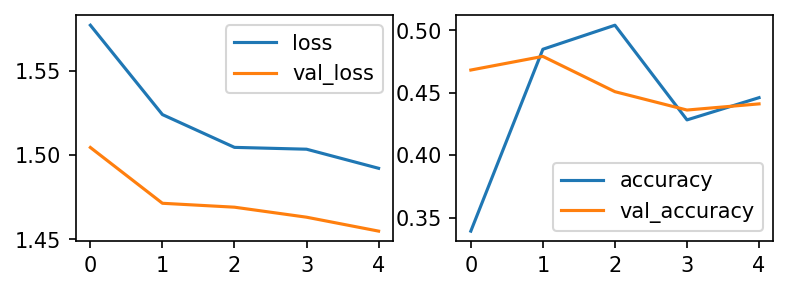

epsilon #1e-07
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 55us/sample - loss: 1.5588 - accuracy: 0.4491 - val_loss: 1.4993 - val_accuracy: 0.4889
Epoch 2/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.5123 - accuracy: 0.5058 - val_loss: 1.4876 - val_accuracy: 0.5058
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4930 - accuracy: 0.4640 - val_loss: 1.4781 - val_accuracy: 0.4962
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4861 - accuracy: 0.4402 - val_loss: 1.4754 - val_accuracy: 0.5344
Epoch 5/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.4870 - accuracy: 0.4389 - val_loss: 1.4722 - val_accuracy: 0.4855


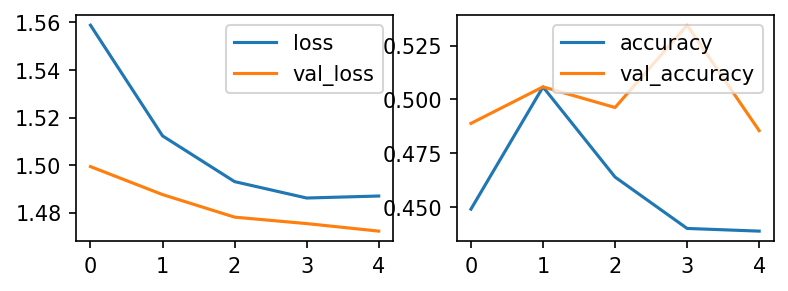

epsilon #1e-08
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 56us/sample - loss: 1.5606 - accuracy: 0.4493 - val_loss: 1.5316 - val_accuracy: 0.4991
Epoch 2/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.5255 - accuracy: 0.4292 - val_loss: 1.4905 - val_accuracy: 0.4959
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5072 - accuracy: 0.4323 - val_loss: 1.4746 - val_accuracy: 0.4871
Epoch 4/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.4972 - accuracy: 0.4304 - val_loss: 1.4709 - val_accuracy: 0.4935
Epoch 5/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.4854 - accuracy: 0.4308 - val_loss: 1.4713 - val_accuracy: 0.4788


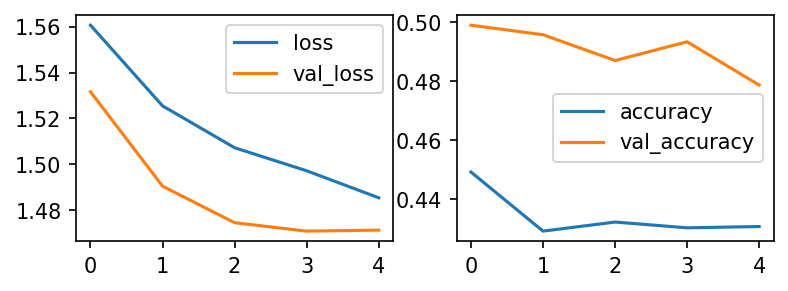

epsilon #1e-09
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 55us/sample - loss: 1.6021 - accuracy: 0.3277 - val_loss: 1.5208 - val_accuracy: 0.4117
Epoch 2/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5421 - accuracy: 0.3479 - val_loss: 1.4770 - val_accuracy: 0.4127
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5078 - accuracy: 0.3704 - val_loss: 1.4712 - val_accuracy: 0.4511
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4990 - accuracy: 0.3911 - val_loss: 1.4714 - val_accuracy: 0.4490
Epoch 5/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4991 - accuracy: 0.3993 - val_loss: 1.4755 - val_accuracy: 0.4584


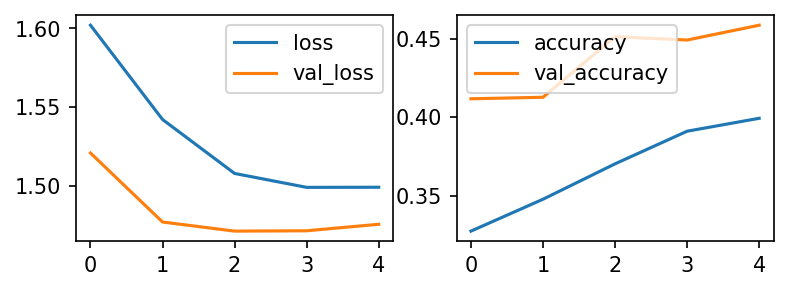

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
epsilon #1e-06,0.457528,0.471924,0.138122,0.235849,0.764706,0.442558,0.351670,0.397114,31.604
epsilon #1e-07,0.518121,0.395996,0.174033,0.257862,0.750000,0.486801,0.369692,0.428247,31.703
epsilon #1e-08,0.509479,0.423096,0.114917,0.305031,0.661765,0.479932,0.346577,0.413254,32.018
epsilon #1e-09,0.484560,0.399902,0.134807,0.330189,0.691176,0.457850,0.358982,0.408416,31.614


In [65]:
rsts = pd.DataFrame()
for optimizer, name in zip(adams,names):
    print(name)
    try: 
        model = create_mlp_2(optimizer)
    except Exception as e: 
        print(e)
        continue
    start = time.time()
    monitor = model.fit(X_train, y_train.values, callbacks=[es],validation_data = (X_val,y_val),
                        class_weight = cls_wgt,
                        batch_size = 32,
                        verbose = 1, epochs = 5)
    end= time.time()
    rsts = rsts.append(evaluation(model,monitor,end-start,name))  
rsts

### beta_1=0.9

In [72]:
rang = [0.93+0.01*x for x in range(5)]
adams = [Adam(beta_1 = x) for x in rang]
names = ['beta_1 #{}'.format(x) for x in rang]
adams, names

([<tensorflow.python.keras.optimizer_v2.adam.Adam at 0x2b7381520a20>,
 ['beta_1 #0.93',
  'beta_1 #0.9400000000000001',
  'beta_1 #0.9500000000000001',
  'beta_1 #0.9600000000000001',
  'beta_1 #0.9700000000000001'])

beta_1 #0.93
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 55us/sample - loss: 1.6066 - accuracy: 0.3340 - val_loss: 1.5593 - val_accuracy: 0.5047
Epoch 2/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5372 - accuracy: 0.4113 - val_loss: 1.4805 - val_accuracy: 0.4818
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5046 - accuracy: 0.4173 - val_loss: 1.4695 - val_accuracy: 0.4901
Epoch 4/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.4908 - accuracy: 0.4099 - val_loss: 1.4674 - val_accuracy: 0.5019
Epoch 5/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4882 - accuracy: 0.4083 - val_loss: 1.4700 - val_accuracy: 0.4642


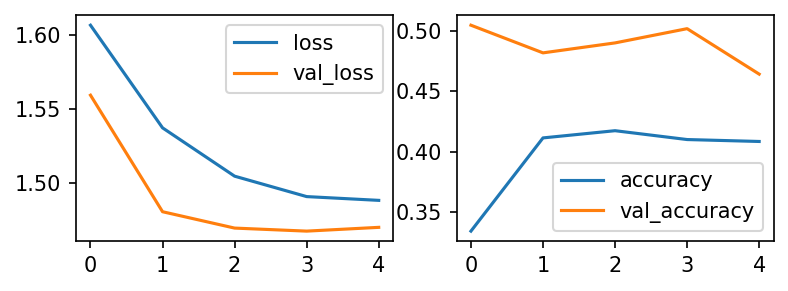

beta_1 #0.9400000000000001
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 56us/sample - loss: 1.5597 - accuracy: 0.3810 - val_loss: 1.4905 - val_accuracy: 0.4269
Epoch 2/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5107 - accuracy: 0.4021 - val_loss: 1.4765 - val_accuracy: 0.4613
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5015 - accuracy: 0.4165 - val_loss: 1.4703 - val_accuracy: 0.5088
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4923 - accuracy: 0.4258 - val_loss: 1.4671 - val_accuracy: 0.4299
Epoch 5/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.4934 - accuracy: 0.3976 - val_loss: 1.4693 - val_accuracy: 0.4694


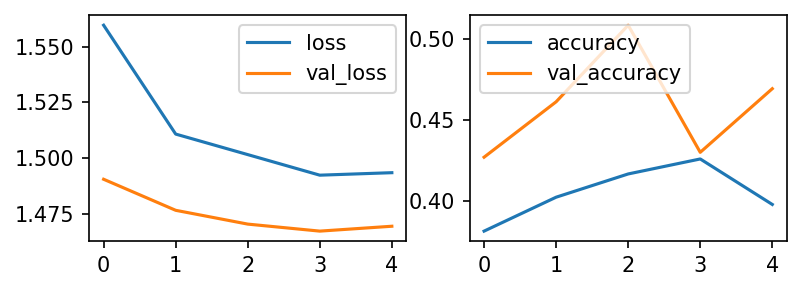

beta_1 #0.9500000000000001
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 56us/sample - loss: 1.5580 - accuracy: 0.3027 - val_loss: 1.4971 - val_accuracy: 0.5020
Epoch 2/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.5139 - accuracy: 0.4540 - val_loss: 1.4797 - val_accuracy: 0.5048
Epoch 3/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.4991 - accuracy: 0.4330 - val_loss: 1.4720 - val_accuracy: 0.4703
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4907 - accuracy: 0.4251 - val_loss: 1.4673 - val_accuracy: 0.4462
Epoch 5/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4876 - accuracy: 0.4090 - val_loss: 1.4684 - val_accuracy: 0.4858


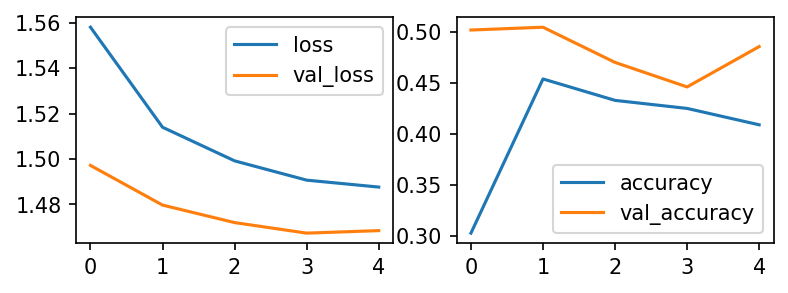

beta_1 #0.9600000000000001
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 55us/sample - loss: 1.6101 - accuracy: 0.3878 - val_loss: 1.5414 - val_accuracy: 0.4996
Epoch 2/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5295 - accuracy: 0.4454 - val_loss: 1.4809 - val_accuracy: 0.4946
Epoch 3/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5033 - accuracy: 0.4311 - val_loss: 1.4793 - val_accuracy: 0.4703
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5029 - accuracy: 0.4250 - val_loss: 1.4745 - val_accuracy: 0.4508
Epoch 5/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4954 - accuracy: 0.4223 - val_loss: 1.4741 - val_accuracy: 0.4438


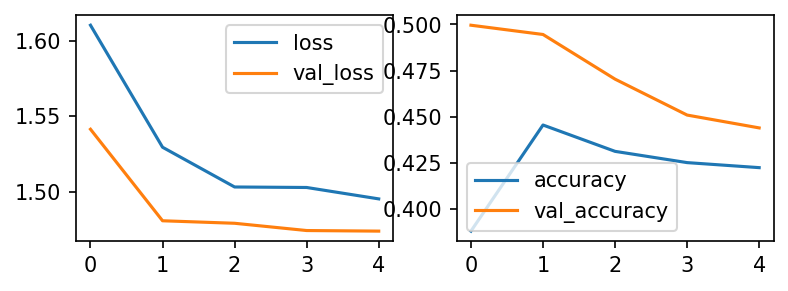

beta_1 #0.9700000000000001
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 55us/sample - loss: 1.5621 - accuracy: 0.3422 - val_loss: 1.4969 - val_accuracy: 0.4426
Epoch 2/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5042 - accuracy: 0.3798 - val_loss: 1.4799 - val_accuracy: 0.4344
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4949 - accuracy: 0.3813 - val_loss: 1.4718 - val_accuracy: 0.4325
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4833 - accuracy: 0.3746 - val_loss: 1.4678 - val_accuracy: 0.4520
Epoch 5/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.4764 - accuracy: 0.3795 - val_loss: 1.4662 - val_accuracy: 0.4636


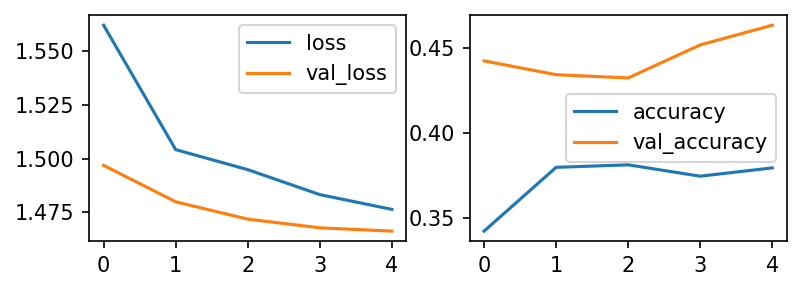

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
beta_1 #0.93,0.483740,0.468750,0.119337,0.295597,0.720588,0.463614,0.356569,0.410091,31.543
beta_1 #0.9400000000000001,0.502413,0.424072,0.115470,0.286164,0.705882,0.474089,0.346149,0.410119,31.878
beta_1 #0.9500000000000001,0.515503,0.434326,0.085635,0.235849,0.779412,0.484406,0.323162,0.403784,32.118
beta_1 #0.9600000000000001,0.470113,0.421631,0.159116,0.298742,0.735294,0.449112,0.369931,0.409522,31.620
beta_1 #0.9700000000000001,0.487241,0.473389,0.102210,0.264151,0.735294,0.465982,0.340529,0.403255,31.811


In [73]:
rsts = pd.DataFrame()
for optimizer, name in zip(adams,names):
    print(name)
    try: 
        model = create_mlp_2(optimizer)
    except Exception as e: 
        print(e)
        continue
    start = time.time()
    monitor = model.fit(X_train, y_train.values, callbacks=[es],validation_data = (X_val,y_val),
                        class_weight = cls_wgt,
                        batch_size = 32,
                        verbose = 1, epochs = 5)
    end= time.time()
    rsts = rsts.append(evaluation(model,monitor,end-start,name))  
rsts

The best parameters for Adam optimizer are:
- lr = 0.001
- $\epsilon=10^{-8}$
- $\beta_1 =0.8$ 

## Node number

In [81]:
def create_mlp_2(node):
    MLP = tf.keras.Sequential([
        keras.layers.Dense(node, # tuning paramete
                           activation='relu', 
                           input_dim=X_train.shape[1],
                           bias_initializer=RandomUniform(minval=-1e-05, maxval=1e-05, seed=None),
                           activity_regularizer=l1(1e-4),
                          ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(5,
                           activation='softmax',
                          activity_regularizer=l1_l2(1e-4,1e-4))])
    MLP.compile(optimizer=Adam(), 
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return MLP

In [78]:
[x for x in range(5,21,5)]

[5, 10, 15, 20]

5
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 56us/sample - loss: 1.5904 - accuracy: 0.3940 - val_loss: 1.5674 - val_accuracy: 0.4283
Epoch 2/5
121580/121580 [==============================] - 6s 50us/sample - loss: 1.5360 - accuracy: 0.5301 - val_loss: 1.5006 - val_accuracy: 0.5241
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5274 - accuracy: 0.5464 - val_loss: 1.4871 - val_accuracy: 0.5150
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5100 - accuracy: 0.5530 - val_loss: 1.4865 - val_accuracy: 0.4940
Epoch 5/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.5151 - accuracy: 0.5416 - val_loss: 1.4852 - val_accuracy: 0.4837


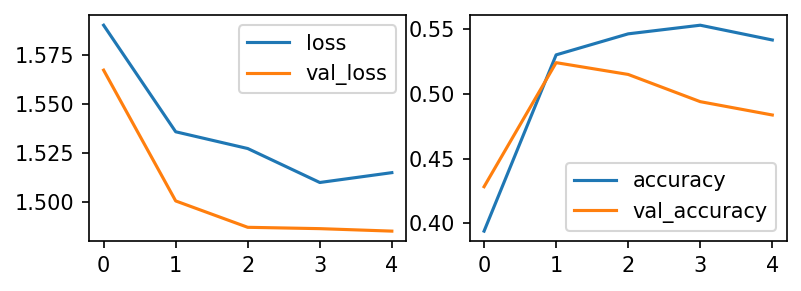

10
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 56us/sample - loss: 1.5946 - accuracy: 0.3446 - val_loss: 1.5429 - val_accuracy: 0.4555
Epoch 2/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5333 - accuracy: 0.3870 - val_loss: 1.4715 - val_accuracy: 0.4402
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.5041 - accuracy: 0.3865 - val_loss: 1.4734 - val_accuracy: 0.4294
Epoch 4/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.4939 - accuracy: 0.3775 - val_loss: 1.4697 - val_accuracy: 0.4158
Epoch 5/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4969 - accuracy: 0.3789 - val_loss: 1.4722 - val_accuracy: 0.4419


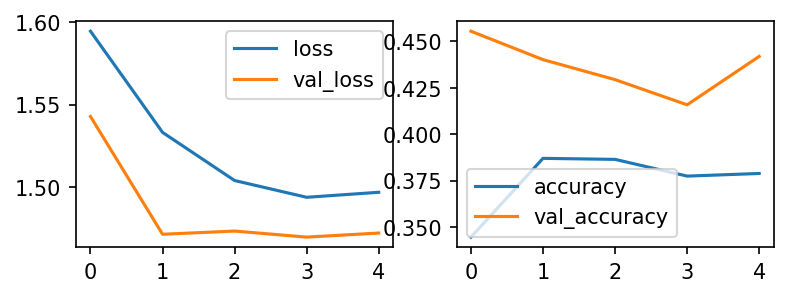

15
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 56us/sample - loss: 1.5474 - accuracy: 0.3904 - val_loss: 1.4905 - val_accuracy: 0.4499
Epoch 2/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.4967 - accuracy: 0.4028 - val_loss: 1.4777 - val_accuracy: 0.4692
Epoch 3/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4865 - accuracy: 0.4061 - val_loss: 1.4773 - val_accuracy: 0.4374
Epoch 4/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.4865 - accuracy: 0.4161 - val_loss: 1.4750 - val_accuracy: 0.4196
Epoch 5/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4904 - accuracy: 0.4170 - val_loss: 1.4687 - val_accuracy: 0.4754


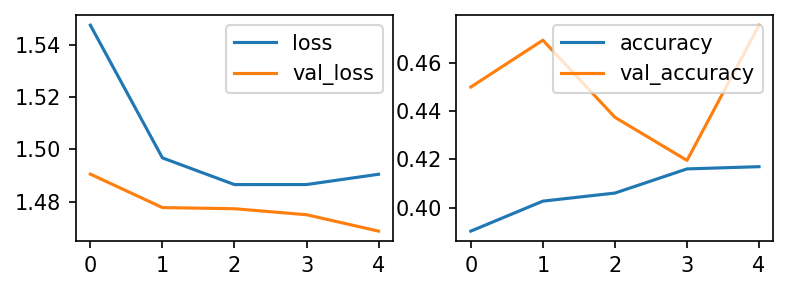

20
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/5
121580/121580 [==============================] - 7s 56us/sample - loss: 1.5449 - accuracy: 0.3354 - val_loss: 1.4984 - val_accuracy: 0.5071
Epoch 2/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.4930 - accuracy: 0.4516 - val_loss: 1.4744 - val_accuracy: 0.4817
Epoch 3/5
121580/121580 [==============================] - 6s 52us/sample - loss: 1.4820 - accuracy: 0.4504 - val_loss: 1.4680 - val_accuracy: 0.4702
Epoch 4/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4761 - accuracy: 0.4590 - val_loss: 1.4666 - val_accuracy: 0.4657
Epoch 5/5
121580/121580 [==============================] - 6s 51us/sample - loss: 1.4659 - accuracy: 0.4414 - val_loss: 1.4761 - val_accuracy: 0.4506


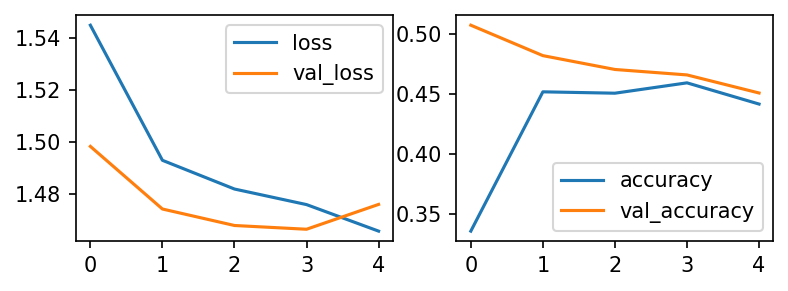

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
5,0.513358,0.480469,0.067403,0.320755,0.676471,0.487248,0.324667,0.405958,31.668
10,0.455856,0.433105,0.172376,0.273585,0.720588,0.438847,0.367566,0.403207,31.740
15,0.500804,0.417236,0.150276,0.386792,0.602941,0.474326,0.374058,0.424192,32.023
20,0.477116,0.425293,0.121547,0.408805,0.661765,0.454349,0.367160,0.410755,31.939


In [82]:
rsts = pd.DataFrame()
for i in range(5,21,5):
    print(i)
    try: 
        model = create_mlp_2(i)
    except Exception as e: 
        print(e)
        continue
    start = time.time()
    monitor = model.fit(X_train, y_train.values, callbacks=[es],validation_data = (X_val,y_val),
                        class_weight = cls_wgt,
                        batch_size = 32,
                        verbose = 1, epochs = 5)
    end= time.time()
    rsts = rsts.append(evaluation(model,monitor,end-start,str(i)))  
rsts

# Final MLP


In [83]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 121580 samples, validate on 30396 samples
Epoch 1/50
121580/121580 [==============================] - 4s 33us/sample - loss: 1.6015 - accuracy: 0.2844 - val_loss: 1.5220 - val_accuracy: 0.4206
Epoch 2/50
121580/121580 [==============================] - 3s 27us/sample - loss: 1.5228 - accuracy: 0.3444 - val_loss: 1.4874 - val_accuracy: 0.4349
Epoch 3/50
121580/121580 [==============================] - 3s 26us/sample - loss: 1.5083 - accuracy: 0.3964 - val_loss: 1.4756 - val_accuracy: 0.4810
Epoch 4/50
121580/121580 [==============================] - 3s 26us/sample - loss: 1.4995 - accuracy: 0.4242 - val_loss: 1.4702 - val_accuracy: 0.4650
Epoch 5/50
121580/121580 [==============================] - 3s 27us/sample - loss: 1.4958 - accuracy: 0.4287 - val_loss: 1.4666 - val_accuracy: 0.4745
Epoch 6/50
121580/121580 [==============================] - 3s 27us/sample - loss: 1.4945 - accuracy: 0.4320 - val_loss: 1.4628 - val_accuracy: 

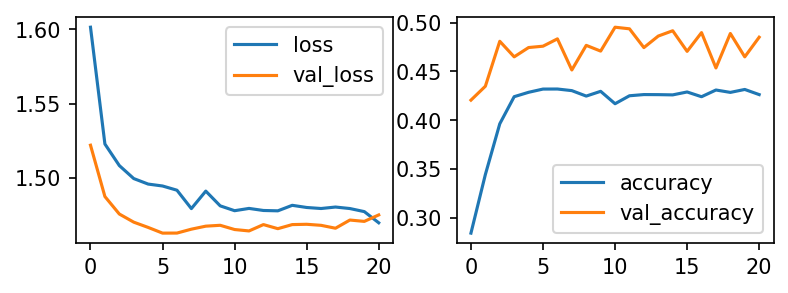

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
20,0.534681,0.387451,0.170718,0.242138,0.735294,0.499381,0.36293,0.431156,68.28


In [84]:
model = create_mlp_2(10)
start = time.time()
monitor = model.fit(X_train, y_train.values, callbacks=[es],validation_data = (X_val,y_val),
                        class_weight = cls_wgt,
                        batch_size = 64,
                        verbose = 1, epochs = 50)
end= time.time()
evaluation(model,monitor,end-start,str(i))

# Variables


In [71]:
%whos

Variable                 Type                               Data/Info
---------------------------------------------------------------------
DT                       DecisionTreeClassifier             DecisionTreeClassifier(class_weight='balanced')
DecisionTreeClassifier   ABCMeta                            <class 'sklearn.tree._cla<...>.DecisionTreeClassifier'>
GNB                      GaussianNB                         GaussianNB()
GaussianNB               ABCMeta                            <class 'sklearn.naive_bayes.GaussianNB'>
LR                       LogisticRegression                 LogisticRegression(class_weight='balanced')
LogisticRegression       type                               <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
Monitor_MLP              History                            <tensorflow.python.keras.<...>object at 0x2b1ba56a95c0>
PCA                      ABCMeta                            <class 'sklearn.decomposition._pca.PCA'>
RF                       